In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 934)
(657450, 8)
validation
(74368, 934)
(74368, 8)
test
(91684, 934)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1647496 (6.28 MB)


Trainable params: 1647496 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:46 - loss: 1.6707 - STD: 0.0845 - MAE: 0.1915

 4/66 [>.............................] - ETA: 1s - loss: 1.4646 - STD: 0.1759 - MAE: 0.1531  

 7/66 [==>...........................] - ETA: 1s - loss: 1.4062 - STD: 0.1925 - MAE: 0.1460

10/66 [===>..........................] - ETA: 1s - loss: 1.3869 - STD: 0.1857 - MAE: 0.1486

12/66 [====>.........................] - ETA: 1s - loss: 1.3788 - STD: 0.1841 - MAE: 0.1491

15/66 [=====>........................] - ETA: 1s - loss: 1.3672 - STD: 0.1876 - MAE: 0.1476

18/66 [=======>......................] - ETA: 1s - loss: 1.3619 - STD: 0.1920 - MAE: 0.1459

21/66 [========>.....................] - ETA: 1s - loss: 1.3540 - STD: 0.1932 - MAE: 0.1453

24/66 [=========>....................] - ETA: 1s - loss: 1.3498 - STD: 0.1918 - MAE: 0.1457

27/66 [===========>..................] - ETA: 0s - loss: 1.3448 - STD: 0.1905 - MAE: 0.1461

30/66 [============>.................] - ETA: 0s - loss: 1.3414 - STD: 0.1908 - MAE: 0.1460

33/66 [==============>...............] - ETA: 0s - loss: 1.3374 - STD: 0.1917 - MAE: 0.1455

36/66 [===============>..............] - ETA: 0s - loss: 1.3353 - STD: 0.1921 - MAE: 0.1453

39/66 [================>.............] - ETA: 0s - loss: 1.3334 - STD: 0.1917 - MAE: 0.1455

42/66 [==================>...........] - ETA: 0s - loss: 1.3314 - STD: 0.1913 - MAE: 0.1456

45/66 [===================>..........] - ETA: 0s - loss: 1.3288 - STD: 0.1914 - MAE: 0.1455

48/66 [====================>.........] - ETA: 0s - loss: 1.3270 - STD: 0.1918 - MAE: 0.1453

51/66 [======================>.......] - ETA: 0s - loss: 1.3260 - STD: 0.1918 - MAE: 0.1453

54/66 [=======================>......] - ETA: 0s - loss: 1.3241 - STD: 0.1915 - MAE: 0.1453

55/66 [========================>.....] - ETA: 0s - loss: 1.3235 - STD: 0.1915 - MAE: 0.1453

58/66 [=========================>....] - ETA: 0s - loss: 1.3216 - STD: 0.1917 - MAE: 0.1451

61/66 [==========================>...] - ETA: 0s - loss: 1.3200 - STD: 0.1919 - MAE: 0.1450

64/66 [============================>.] - ETA: 0s - loss: 1.3181 - STD: 0.1916 - MAE: 0.1451

66/66 [==============================] - 5s 52ms/step - loss: 1.3169 - STD: 0.1916 - MAE: 0.1450 - val_loss: 1.1969 - val_STD: 0.1984 - val_MAE: 0.1367


Epoch 2/10000


 1/66 [..............................] - ETA: 3s - loss: 1.2478 - STD: 0.1972 - MAE: 0.1397

 4/66 [>.............................] - ETA: 1s - loss: 1.2606 - STD: 0.1981 - MAE: 0.1400

 7/66 [==>...........................] - ETA: 1s - loss: 1.2597 - STD: 0.1949 - MAE: 0.1412

10/66 [===>..........................] - ETA: 1s - loss: 1.2596 - STD: 0.1954 - MAE: 0.1410

13/66 [====>.........................] - ETA: 1s - loss: 1.2586 - STD: 0.1959 - MAE: 0.1409

16/66 [======>.......................] - ETA: 1s - loss: 1.2563 - STD: 0.1955 - MAE: 0.1409

19/66 [=======>......................] - ETA: 1s - loss: 1.2543 - STD: 0.1967 - MAE: 0.1404

22/66 [=========>....................] - ETA: 1s - loss: 1.2529 - STD: 0.1960 - MAE: 0.1407

25/66 [==========>...................] - ETA: 0s - loss: 1.2490 - STD: 0.1970 - MAE: 0.1402

28/66 [===========>..................] - ETA: 0s - loss: 1.2466 - STD: 0.1969 - MAE: 0.1401

31/66 [=============>................] - ETA: 0s - loss: 1.2428 - STD: 0.1975 - MAE: 0.1398

34/66 [==============>...............] - ETA: 0s - loss: 1.2403 - STD: 0.1974 - MAE: 0.1397

37/66 [===============>..............] - ETA: 0s - loss: 1.2371 - STD: 0.1977 - MAE: 0.1395

40/66 [=================>............] - ETA: 0s - loss: 1.2331 - STD: 0.1980 - MAE: 0.1393

43/66 [==================>...........] - ETA: 0s - loss: 1.2287 - STD: 0.1982 - MAE: 0.1391

46/66 [===================>..........] - ETA: 0s - loss: 1.2248 - STD: 0.1983 - MAE: 0.1389

49/66 [=====================>........] - ETA: 0s - loss: 1.2203 - STD: 0.1986 - MAE: 0.1387

52/66 [======================>.......] - ETA: 0s - loss: 1.2157 - STD: 0.1987 - MAE: 0.1385

55/66 [========================>.....] - ETA: 0s - loss: 1.2113 - STD: 0.1989 - MAE: 0.1383

58/66 [=========================>....] - ETA: 0s - loss: 1.2080 - STD: 0.1991 - MAE: 0.1382

61/66 [==========================>...] - ETA: 0s - loss: 1.2038 - STD: 0.1995 - MAE: 0.1379

64/66 [============================>.] - ETA: 0s - loss: 1.1997 - STD: 0.1996 - MAE: 0.1377

66/66 [==============================] - 2s 27ms/step - loss: 1.1976 - STD: 0.1999 - MAE: 0.1375 - val_loss: 1.0320 - val_STD: 0.2040 - val_MAE: 0.1283


Epoch 3/10000


 1/66 [..............................] - ETA: 3s - loss: 1.1227 - STD: 0.1948 - MAE: 0.1376

 3/66 [>.............................] - ETA: 1s - loss: 1.1193 - STD: 0.1997 - MAE: 0.1357

 5/66 [=>............................] - ETA: 1s - loss: 1.1091 - STD: 0.2031 - MAE: 0.1337

 8/66 [==>...........................] - ETA: 1s - loss: 1.1035 - STD: 0.2037 - MAE: 0.1333

11/66 [====>.........................] - ETA: 1s - loss: 1.0938 - STD: 0.2052 - MAE: 0.1322

14/66 [=====>........................] - ETA: 1s - loss: 1.0893 - STD: 0.2058 - MAE: 0.1317

17/66 [======>.......................] - ETA: 1s - loss: 1.0848 - STD: 0.2065 - MAE: 0.1312

20/66 [========>.....................] - ETA: 1s - loss: 1.0802 - STD: 0.2070 - MAE: 0.1307

23/66 [=========>....................] - ETA: 1s - loss: 1.0769 - STD: 0.2078 - MAE: 0.1303

26/66 [==========>...................] - ETA: 0s - loss: 1.0721 - STD: 0.2083 - MAE: 0.1299

29/66 [============>.................] - ETA: 0s - loss: 1.0692 - STD: 0.2088 - MAE: 0.1296

32/66 [=============>................] - ETA: 0s - loss: 1.0664 - STD: 0.2091 - MAE: 0.1293

35/66 [==============>...............] - ETA: 0s - loss: 1.0639 - STD: 0.2095 - MAE: 0.1291

38/66 [================>.............] - ETA: 0s - loss: 1.0602 - STD: 0.2099 - MAE: 0.1287

41/66 [=================>............] - ETA: 0s - loss: 1.0566 - STD: 0.2102 - MAE: 0.1284

44/66 [===================>..........] - ETA: 0s - loss: 1.0531 - STD: 0.2107 - MAE: 0.1281

47/66 [====================>.........] - ETA: 0s - loss: 1.0494 - STD: 0.2111 - MAE: 0.1277

50/66 [=====================>........] - ETA: 0s - loss: 1.0463 - STD: 0.2114 - MAE: 0.1274

53/66 [=======================>......] - ETA: 0s - loss: 1.0424 - STD: 0.2119 - MAE: 0.1270

56/66 [========================>.....] - ETA: 0s - loss: 1.0387 - STD: 0.2123 - MAE: 0.1267

59/66 [=========================>....] - ETA: 0s - loss: 1.0353 - STD: 0.2127 - MAE: 0.1264

62/66 [===========================>..] - ETA: 0s - loss: 1.0318 - STD: 0.2131 - MAE: 0.1260

65/66 [============================>.] - ETA: 0s - loss: 1.0281 - STD: 0.2135 - MAE: 0.1257

66/66 [==============================] - 2s 27ms/step - loss: 1.0270 - STD: 0.2135 - MAE: 0.1256 - val_loss: 0.9119 - val_STD: 0.2359 - val_MAE: 0.1090


Epoch 4/10000


 1/66 [..............................] - ETA: 3s - loss: 0.9690 - STD: 0.2289 - MAE: 0.1169

 4/66 [>.............................] - ETA: 1s - loss: 0.9603 - STD: 0.2234 - MAE: 0.1188

 7/66 [==>...........................] - ETA: 1s - loss: 0.9564 - STD: 0.2213 - MAE: 0.1195

10/66 [===>..........................] - ETA: 1s - loss: 0.9572 - STD: 0.2212 - MAE: 0.1195

13/66 [====>.........................] - ETA: 1s - loss: 0.9551 - STD: 0.2220 - MAE: 0.1191

16/66 [======>.......................] - ETA: 1s - loss: 0.9513 - STD: 0.2228 - MAE: 0.1186

19/66 [=======>......................] - ETA: 1s - loss: 0.9465 - STD: 0.2228 - MAE: 0.1183

22/66 [=========>....................] - ETA: 1s - loss: 0.9443 - STD: 0.2225 - MAE: 0.1184

25/66 [==========>...................] - ETA: 0s - loss: 0.9409 - STD: 0.2230 - MAE: 0.1180

28/66 [===========>..................] - ETA: 0s - loss: 0.9377 - STD: 0.2233 - MAE: 0.1178

31/66 [=============>................] - ETA: 0s - loss: 0.9348 - STD: 0.2233 - MAE: 0.1176

34/66 [==============>...............] - ETA: 0s - loss: 0.9321 - STD: 0.2236 - MAE: 0.1174

37/66 [===============>..............] - ETA: 0s - loss: 0.9295 - STD: 0.2239 - MAE: 0.1171

40/66 [=================>............] - ETA: 0s - loss: 0.9267 - STD: 0.2242 - MAE: 0.1169

43/66 [==================>...........] - ETA: 0s - loss: 0.9246 - STD: 0.2244 - MAE: 0.1167

46/66 [===================>..........] - ETA: 0s - loss: 0.9234 - STD: 0.2244 - MAE: 0.1167

49/66 [=====================>........] - ETA: 0s - loss: 0.9211 - STD: 0.2246 - MAE: 0.1165

52/66 [======================>.......] - ETA: 0s - loss: 0.9197 - STD: 0.2247 - MAE: 0.1164

55/66 [========================>.....] - ETA: 0s - loss: 0.9174 - STD: 0.2249 - MAE: 0.1162

58/66 [=========================>....] - ETA: 0s - loss: 0.9157 - STD: 0.2251 - MAE: 0.1160

61/66 [==========================>...] - ETA: 0s - loss: 0.9143 - STD: 0.2252 - MAE: 0.1160

64/66 [============================>.] - ETA: 0s - loss: 0.9128 - STD: 0.2253 - MAE: 0.1158

66/66 [==============================] - 2s 27ms/step - loss: 0.9118 - STD: 0.2253 - MAE: 0.1158 - val_loss: 0.8621 - val_STD: 0.2373 - val_MAE: 0.1061


Epoch 5/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8778 - STD: 0.2321 - MAE: 0.1116

 4/66 [>.............................] - ETA: 1s - loss: 0.8746 - STD: 0.2290 - MAE: 0.1127

 7/66 [==>...........................] - ETA: 1s - loss: 0.8747 - STD: 0.2299 - MAE: 0.1122

10/66 [===>..........................] - ETA: 1s - loss: 0.8766 - STD: 0.2295 - MAE: 0.1125

13/66 [====>.........................] - ETA: 1s - loss: 0.8787 - STD: 0.2291 - MAE: 0.1128

16/66 [======>.......................] - ETA: 1s - loss: 0.8778 - STD: 0.2291 - MAE: 0.1128

19/66 [=======>......................] - ETA: 1s - loss: 0.8770 - STD: 0.2290 - MAE: 0.1128

22/66 [=========>....................] - ETA: 1s - loss: 0.8765 - STD: 0.2289 - MAE: 0.1128

25/66 [==========>...................] - ETA: 1s - loss: 0.8752 - STD: 0.2290 - MAE: 0.1127

28/66 [===========>..................] - ETA: 0s - loss: 0.8741 - STD: 0.2290 - MAE: 0.1126

31/66 [=============>................] - ETA: 0s - loss: 0.8730 - STD: 0.2293 - MAE: 0.1124

34/66 [==============>...............] - ETA: 0s - loss: 0.8726 - STD: 0.2294 - MAE: 0.1124

37/66 [===============>..............] - ETA: 0s - loss: 0.8713 - STD: 0.2296 - MAE: 0.1122

40/66 [=================>............] - ETA: 0s - loss: 0.8708 - STD: 0.2297 - MAE: 0.1122

43/66 [==================>...........] - ETA: 0s - loss: 0.8696 - STD: 0.2297 - MAE: 0.1121

46/66 [===================>..........] - ETA: 0s - loss: 0.8686 - STD: 0.2298 - MAE: 0.1120

49/66 [=====================>........] - ETA: 0s - loss: 0.8683 - STD: 0.2299 - MAE: 0.1120

52/66 [======================>.......] - ETA: 0s - loss: 0.8672 - STD: 0.2299 - MAE: 0.1119

55/66 [========================>.....] - ETA: 0s - loss: 0.8662 - STD: 0.2300 - MAE: 0.1118

58/66 [=========================>....] - ETA: 0s - loss: 0.8657 - STD: 0.2302 - MAE: 0.1117

61/66 [==========================>...] - ETA: 0s - loss: 0.8647 - STD: 0.2302 - MAE: 0.1117

64/66 [============================>.] - ETA: 0s - loss: 0.8642 - STD: 0.2302 - MAE: 0.1117

66/66 [==============================] - 2s 27ms/step - loss: 0.8639 - STD: 0.2303 - MAE: 0.1116 - val_loss: 0.8387 - val_STD: 0.2361 - val_MAE: 0.1056


Epoch 6/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8504 - STD: 0.2306 - MAE: 0.1108

 3/66 [>.............................] - ETA: 1s - loss: 0.8493 - STD: 0.2328 - MAE: 0.1099

 6/66 [=>............................] - ETA: 1s - loss: 0.8551 - STD: 0.2319 - MAE: 0.1105

 9/66 [===>..........................] - ETA: 1s - loss: 0.8567 - STD: 0.2313 - MAE: 0.1109

12/66 [====>.........................] - ETA: 1s - loss: 0.8515 - STD: 0.2313 - MAE: 0.1106

15/66 [=====>........................] - ETA: 1s - loss: 0.8497 - STD: 0.2315 - MAE: 0.1105

18/66 [=======>......................] - ETA: 1s - loss: 0.8502 - STD: 0.2316 - MAE: 0.1105

21/66 [========>.....................] - ETA: 1s - loss: 0.8482 - STD: 0.2317 - MAE: 0.1103

24/66 [=========>....................] - ETA: 1s - loss: 0.8486 - STD: 0.2319 - MAE: 0.1103

27/66 [===========>..................] - ETA: 0s - loss: 0.8472 - STD: 0.2320 - MAE: 0.1102

30/66 [============>.................] - ETA: 0s - loss: 0.8460 - STD: 0.2322 - MAE: 0.1100

33/66 [==============>...............] - ETA: 0s - loss: 0.8453 - STD: 0.2323 - MAE: 0.1099

36/66 [===============>..............] - ETA: 0s - loss: 0.8455 - STD: 0.2324 - MAE: 0.1099

39/66 [================>.............] - ETA: 0s - loss: 0.8450 - STD: 0.2325 - MAE: 0.1098

42/66 [==================>...........] - ETA: 0s - loss: 0.8444 - STD: 0.2325 - MAE: 0.1098

45/66 [===================>..........] - ETA: 0s - loss: 0.8434 - STD: 0.2325 - MAE: 0.1097

48/66 [====================>.........] - ETA: 0s - loss: 0.8428 - STD: 0.2325 - MAE: 0.1097

51/66 [======================>.......] - ETA: 0s - loss: 0.8420 - STD: 0.2326 - MAE: 0.1096

54/66 [=======================>......] - ETA: 0s - loss: 0.8414 - STD: 0.2327 - MAE: 0.1096

57/66 [========================>.....] - ETA: 0s - loss: 0.8408 - STD: 0.2327 - MAE: 0.1095

60/66 [==========================>...] - ETA: 0s - loss: 0.8396 - STD: 0.2329 - MAE: 0.1094

63/66 [===========================>..] - ETA: 0s - loss: 0.8391 - STD: 0.2330 - MAE: 0.1093

66/66 [==============================] - ETA: 0s - loss: 0.8388 - STD: 0.2330 - MAE: 0.1093

66/66 [==============================] - 2s 28ms/step - loss: 0.8388 - STD: 0.2330 - MAE: 0.1093 - val_loss: 0.8260 - val_STD: 0.2300 - val_MAE: 0.1081


Epoch 7/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8261 - STD: 0.2251 - MAE: 0.1126

 3/66 [>.............................] - ETA: 1s - loss: 0.8232 - STD: 0.2343 - MAE: 0.1081

 6/66 [=>............................] - ETA: 1s - loss: 0.8249 - STD: 0.2342 - MAE: 0.1082

 9/66 [===>..........................] - ETA: 1s - loss: 0.8237 - STD: 0.2345 - MAE: 0.1079

12/66 [====>.........................] - ETA: 1s - loss: 0.8228 - STD: 0.2346 - MAE: 0.1078

15/66 [=====>........................] - ETA: 1s - loss: 0.8224 - STD: 0.2345 - MAE: 0.1078

18/66 [=======>......................] - ETA: 1s - loss: 0.8227 - STD: 0.2342 - MAE: 0.1080

21/66 [========>.....................] - ETA: 1s - loss: 0.8217 - STD: 0.2344 - MAE: 0.1078

24/66 [=========>....................] - ETA: 1s - loss: 0.8208 - STD: 0.2343 - MAE: 0.1078

27/66 [===========>..................] - ETA: 0s - loss: 0.8194 - STD: 0.2344 - MAE: 0.1077

30/66 [============>.................] - ETA: 0s - loss: 0.8199 - STD: 0.2344 - MAE: 0.1078

33/66 [==============>...............] - ETA: 0s - loss: 0.8210 - STD: 0.2347 - MAE: 0.1077

36/66 [===============>..............] - ETA: 0s - loss: 0.8208 - STD: 0.2350 - MAE: 0.1076

39/66 [================>.............] - ETA: 0s - loss: 0.8206 - STD: 0.2348 - MAE: 0.1077

42/66 [==================>...........] - ETA: 0s - loss: 0.8207 - STD: 0.2349 - MAE: 0.1076

45/66 [===================>..........] - ETA: 0s - loss: 0.8212 - STD: 0.2348 - MAE: 0.1077

48/66 [====================>.........] - ETA: 0s - loss: 0.8203 - STD: 0.2348 - MAE: 0.1077

51/66 [======================>.......] - ETA: 0s - loss: 0.8191 - STD: 0.2348 - MAE: 0.1076

54/66 [=======================>......] - ETA: 0s - loss: 0.8190 - STD: 0.2348 - MAE: 0.1076

57/66 [========================>.....] - ETA: 0s - loss: 0.8183 - STD: 0.2349 - MAE: 0.1075

60/66 [==========================>...] - ETA: 0s - loss: 0.8176 - STD: 0.2349 - MAE: 0.1074

63/66 [===========================>..] - ETA: 0s - loss: 0.8169 - STD: 0.2350 - MAE: 0.1074

66/66 [==============================] - ETA: 0s - loss: 0.8169 - STD: 0.2350 - MAE: 0.1074

66/66 [==============================] - 2s 28ms/step - loss: 0.8169 - STD: 0.2350 - MAE: 0.1074 - val_loss: 0.8108 - val_STD: 0.2407 - val_MAE: 0.1025


Epoch 8/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8069 - STD: 0.2357 - MAE: 0.1062

 3/66 [>.............................] - ETA: 1s - loss: 0.8119 - STD: 0.2355 - MAE: 0.1070

 6/66 [=>............................] - ETA: 1s - loss: 0.8091 - STD: 0.2356 - MAE: 0.1069

 9/66 [===>..........................] - ETA: 1s - loss: 0.8152 - STD: 0.2364 - MAE: 0.1068

12/66 [====>.........................] - ETA: 1s - loss: 0.8154 - STD: 0.2365 - MAE: 0.1067

15/66 [=====>........................] - ETA: 1s - loss: 0.8157 - STD: 0.2365 - MAE: 0.1068

18/66 [=======>......................] - ETA: 1s - loss: 0.8161 - STD: 0.2366 - MAE: 0.1067

21/66 [========>.....................] - ETA: 1s - loss: 0.8142 - STD: 0.2366 - MAE: 0.1067

24/66 [=========>....................] - ETA: 1s - loss: 0.8139 - STD: 0.2363 - MAE: 0.1068

27/66 [===========>..................] - ETA: 0s - loss: 0.8118 - STD: 0.2363 - MAE: 0.1067

30/66 [============>.................] - ETA: 0s - loss: 0.8098 - STD: 0.2364 - MAE: 0.1065

33/66 [==============>...............] - ETA: 0s - loss: 0.8086 - STD: 0.2365 - MAE: 0.1064

36/66 [===============>..............] - ETA: 0s - loss: 0.8069 - STD: 0.2365 - MAE: 0.1063

39/66 [================>.............] - ETA: 0s - loss: 0.8065 - STD: 0.2364 - MAE: 0.1064

42/66 [==================>...........] - ETA: 0s - loss: 0.8050 - STD: 0.2365 - MAE: 0.1062

45/66 [===================>..........] - ETA: 0s - loss: 0.8033 - STD: 0.2366 - MAE: 0.1061

48/66 [====================>.........] - ETA: 0s - loss: 0.8024 - STD: 0.2366 - MAE: 0.1061

50/66 [=====================>........] - ETA: 0s - loss: 0.8019 - STD: 0.2366 - MAE: 0.1060

53/66 [=======================>......] - ETA: 0s - loss: 0.8012 - STD: 0.2367 - MAE: 0.1059

56/66 [========================>.....] - ETA: 0s - loss: 0.8006 - STD: 0.2368 - MAE: 0.1058

59/66 [=========================>....] - ETA: 0s - loss: 0.8005 - STD: 0.2369 - MAE: 0.1058

62/66 [===========================>..] - ETA: 0s - loss: 0.8012 - STD: 0.2370 - MAE: 0.1058

65/66 [============================>.] - ETA: 0s - loss: 0.8019 - STD: 0.2371 - MAE: 0.1057

66/66 [==============================] - 2s 27ms/step - loss: 0.8017 - STD: 0.2370 - MAE: 0.1058 - val_loss: 0.8270 - val_STD: 0.2377 - val_MAE: 0.1051


Epoch 9/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8297 - STD: 0.2306 - MAE: 0.1098

 4/66 [>.............................] - ETA: 1s - loss: 0.8107 - STD: 0.2386 - MAE: 0.1052

 7/66 [==>...........................] - ETA: 1s - loss: 0.8045 - STD: 0.2370 - MAE: 0.1058

 9/66 [===>..........................] - ETA: 1s - loss: 0.8032 - STD: 0.2370 - MAE: 0.1057

12/66 [====>.........................] - ETA: 1s - loss: 0.8018 - STD: 0.2370 - MAE: 0.1057

15/66 [=====>........................] - ETA: 1s - loss: 0.7983 - STD: 0.2370 - MAE: 0.1056

18/66 [=======>......................] - ETA: 1s - loss: 0.7974 - STD: 0.2375 - MAE: 0.1053

21/66 [========>.....................] - ETA: 1s - loss: 0.7961 - STD: 0.2375 - MAE: 0.1052

24/66 [=========>....................] - ETA: 1s - loss: 0.7948 - STD: 0.2375 - MAE: 0.1052

27/66 [===========>..................] - ETA: 0s - loss: 0.7938 - STD: 0.2377 - MAE: 0.1050

30/66 [============>.................] - ETA: 0s - loss: 0.7916 - STD: 0.2380 - MAE: 0.1048

33/66 [==============>...............] - ETA: 0s - loss: 0.7908 - STD: 0.2379 - MAE: 0.1048

36/66 [===============>..............] - ETA: 0s - loss: 0.7901 - STD: 0.2380 - MAE: 0.1047

39/66 [================>.............] - ETA: 0s - loss: 0.7898 - STD: 0.2380 - MAE: 0.1047

42/66 [==================>...........] - ETA: 0s - loss: 0.7895 - STD: 0.2381 - MAE: 0.1047

45/66 [===================>..........] - ETA: 0s - loss: 0.7887 - STD: 0.2381 - MAE: 0.1046

48/66 [====================>.........] - ETA: 0s - loss: 0.7875 - STD: 0.2382 - MAE: 0.1045

51/66 [======================>.......] - ETA: 0s - loss: 0.7865 - STD: 0.2383 - MAE: 0.1044

54/66 [=======================>......] - ETA: 0s - loss: 0.7857 - STD: 0.2382 - MAE: 0.1044

57/66 [========================>.....] - ETA: 0s - loss: 0.7855 - STD: 0.2383 - MAE: 0.1044

60/66 [==========================>...] - ETA: 0s - loss: 0.7847 - STD: 0.2385 - MAE: 0.1043

62/66 [===========================>..] - ETA: 0s - loss: 0.7848 - STD: 0.2383 - MAE: 0.1043

65/66 [============================>.] - ETA: 0s - loss: 0.7845 - STD: 0.2385 - MAE: 0.1042

66/66 [==============================] - 2s 27ms/step - loss: 0.7843 - STD: 0.2385 - MAE: 0.1042 - val_loss: 0.7813 - val_STD: 0.2490 - val_MAE: 0.0974


Epoch 10/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7625 - STD: 0.2430 - MAE: 0.1006

 4/66 [>.............................] - ETA: 1s - loss: 0.7699 - STD: 0.2407 - MAE: 0.1024

 7/66 [==>...........................] - ETA: 1s - loss: 0.7726 - STD: 0.2398 - MAE: 0.1031

10/66 [===>..........................] - ETA: 1s - loss: 0.7763 - STD: 0.2396 - MAE: 0.1033

13/66 [====>.........................] - ETA: 1s - loss: 0.7726 - STD: 0.2398 - MAE: 0.1031

16/66 [======>.......................] - ETA: 1s - loss: 0.7719 - STD: 0.2395 - MAE: 0.1032

19/66 [=======>......................] - ETA: 1s - loss: 0.7732 - STD: 0.2396 - MAE: 0.1032

22/66 [=========>....................] - ETA: 1s - loss: 0.7731 - STD: 0.2398 - MAE: 0.1031

25/66 [==========>...................] - ETA: 0s - loss: 0.7727 - STD: 0.2399 - MAE: 0.1030

28/66 [===========>..................] - ETA: 0s - loss: 0.7749 - STD: 0.2395 - MAE: 0.1033

31/66 [=============>................] - ETA: 0s - loss: 0.7744 - STD: 0.2396 - MAE: 0.1032

34/66 [==============>...............] - ETA: 0s - loss: 0.7733 - STD: 0.2398 - MAE: 0.1031

37/66 [===============>..............] - ETA: 0s - loss: 0.7726 - STD: 0.2398 - MAE: 0.1031

40/66 [=================>............] - ETA: 0s - loss: 0.7716 - STD: 0.2398 - MAE: 0.1030

43/66 [==================>...........] - ETA: 0s - loss: 0.7724 - STD: 0.2399 - MAE: 0.1030

46/66 [===================>..........] - ETA: 0s - loss: 0.7725 - STD: 0.2400 - MAE: 0.1030

49/66 [=====================>........] - ETA: 0s - loss: 0.7722 - STD: 0.2402 - MAE: 0.1028

52/66 [======================>.......] - ETA: 0s - loss: 0.7732 - STD: 0.2403 - MAE: 0.1029

55/66 [========================>.....] - ETA: 0s - loss: 0.7738 - STD: 0.2403 - MAE: 0.1029

58/66 [=========================>....] - ETA: 0s - loss: 0.7746 - STD: 0.2402 - MAE: 0.1030

61/66 [==========================>...] - ETA: 0s - loss: 0.7748 - STD: 0.2403 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7747 - STD: 0.2403 - MAE: 0.1030

66/66 [==============================] - 2s 27ms/step - loss: 0.7743 - STD: 0.2400 - MAE: 0.1031 - val_loss: 0.7943 - val_STD: 0.2577 - val_MAE: 0.0945


Epoch 11/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7812 - STD: 0.2505 - MAE: 0.0991

 4/66 [>.............................] - ETA: 1s - loss: 0.7701 - STD: 0.2409 - MAE: 0.1028

 7/66 [==>...........................] - ETA: 1s - loss: 0.7677 - STD: 0.2408 - MAE: 0.1025

10/66 [===>..........................] - ETA: 1s - loss: 0.7638 - STD: 0.2406 - MAE: 0.1024

13/66 [====>.........................] - ETA: 1s - loss: 0.7605 - STD: 0.2404 - MAE: 0.1022

16/66 [======>.......................] - ETA: 1s - loss: 0.7600 - STD: 0.2402 - MAE: 0.1023

19/66 [=======>......................] - ETA: 1s - loss: 0.7590 - STD: 0.2405 - MAE: 0.1021

22/66 [=========>....................] - ETA: 1s - loss: 0.7602 - STD: 0.2405 - MAE: 0.1022

25/66 [==========>...................] - ETA: 0s - loss: 0.7611 - STD: 0.2405 - MAE: 0.1023

27/66 [===========>..................] - ETA: 0s - loss: 0.7605 - STD: 0.2406 - MAE: 0.1022

30/66 [============>.................] - ETA: 0s - loss: 0.7606 - STD: 0.2404 - MAE: 0.1022

33/66 [==============>...............] - ETA: 0s - loss: 0.7612 - STD: 0.2406 - MAE: 0.1022

36/66 [===============>..............] - ETA: 0s - loss: 0.7617 - STD: 0.2407 - MAE: 0.1022

39/66 [================>.............] - ETA: 0s - loss: 0.7616 - STD: 0.2407 - MAE: 0.1022

42/66 [==================>...........] - ETA: 0s - loss: 0.7610 - STD: 0.2407 - MAE: 0.1021

45/66 [===================>..........] - ETA: 0s - loss: 0.7608 - STD: 0.2408 - MAE: 0.1021

48/66 [====================>.........] - ETA: 0s - loss: 0.7606 - STD: 0.2409 - MAE: 0.1020

51/66 [======================>.......] - ETA: 0s - loss: 0.7602 - STD: 0.2410 - MAE: 0.1019

54/66 [=======================>......] - ETA: 0s - loss: 0.7599 - STD: 0.2409 - MAE: 0.1019

57/66 [========================>.....] - ETA: 0s - loss: 0.7591 - STD: 0.2409 - MAE: 0.1019

60/66 [==========================>...] - ETA: 0s - loss: 0.7581 - STD: 0.2411 - MAE: 0.1018

63/66 [===========================>..] - ETA: 0s - loss: 0.7579 - STD: 0.2411 - MAE: 0.1017

66/66 [==============================] - ETA: 0s - loss: 0.7570 - STD: 0.2412 - MAE: 0.1017

66/66 [==============================] - 2s 28ms/step - loss: 0.7570 - STD: 0.2412 - MAE: 0.1017 - val_loss: 0.7631 - val_STD: 0.2478 - val_MAE: 0.0975


Epoch 12/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7529 - STD: 0.2425 - MAE: 0.1008

 3/66 [>.............................] - ETA: 1s - loss: 0.7491 - STD: 0.2419 - MAE: 0.1008

 6/66 [=>............................] - ETA: 1s - loss: 0.7516 - STD: 0.2419 - MAE: 0.1009

 9/66 [===>..........................] - ETA: 1s - loss: 0.7543 - STD: 0.2425 - MAE: 0.1008

12/66 [====>.........................] - ETA: 1s - loss: 0.7552 - STD: 0.2431 - MAE: 0.1006

15/66 [=====>........................] - ETA: 1s - loss: 0.7580 - STD: 0.2426 - MAE: 0.1010

18/66 [=======>......................] - ETA: 1s - loss: 0.7572 - STD: 0.2425 - MAE: 0.1010

21/66 [========>.....................] - ETA: 1s - loss: 0.7566 - STD: 0.2425 - MAE: 0.1010

24/66 [=========>....................] - ETA: 1s - loss: 0.7567 - STD: 0.2424 - MAE: 0.1011

27/66 [===========>..................] - ETA: 0s - loss: 0.7561 - STD: 0.2422 - MAE: 0.1011

30/66 [============>.................] - ETA: 0s - loss: 0.7564 - STD: 0.2420 - MAE: 0.1012

33/66 [==============>...............] - ETA: 0s - loss: 0.7567 - STD: 0.2420 - MAE: 0.1012

36/66 [===============>..............] - ETA: 0s - loss: 0.7555 - STD: 0.2422 - MAE: 0.1011

39/66 [================>.............] - ETA: 0s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1010

42/66 [==================>...........] - ETA: 0s - loss: 0.7535 - STD: 0.2422 - MAE: 0.1010

45/66 [===================>..........] - ETA: 0s - loss: 0.7533 - STD: 0.2422 - MAE: 0.1010

48/66 [====================>.........] - ETA: 0s - loss: 0.7525 - STD: 0.2423 - MAE: 0.1009

51/66 [======================>.......] - ETA: 0s - loss: 0.7522 - STD: 0.2424 - MAE: 0.1008

54/66 [=======================>......] - ETA: 0s - loss: 0.7516 - STD: 0.2423 - MAE: 0.1008

57/66 [========================>.....] - ETA: 0s - loss: 0.7506 - STD: 0.2424 - MAE: 0.1007

60/66 [==========================>...] - ETA: 0s - loss: 0.7504 - STD: 0.2425 - MAE: 0.1007

62/66 [===========================>..] - ETA: 0s - loss: 0.7503 - STD: 0.2424 - MAE: 0.1007

65/66 [============================>.] - ETA: 0s - loss: 0.7501 - STD: 0.2424 - MAE: 0.1007

66/66 [==============================] - 2s 27ms/step - loss: 0.7502 - STD: 0.2425 - MAE: 0.1007 - val_loss: 0.7733 - val_STD: 0.2507 - val_MAE: 0.0969


Epoch 13/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7456 - STD: 0.2450 - MAE: 0.0994

 4/66 [>.............................] - ETA: 1s - loss: 0.7448 - STD: 0.2439 - MAE: 0.0996

 7/66 [==>...........................] - ETA: 1s - loss: 0.7468 - STD: 0.2437 - MAE: 0.1000

10/66 [===>..........................] - ETA: 1s - loss: 0.7443 - STD: 0.2435 - MAE: 0.1000

13/66 [====>.........................] - ETA: 1s - loss: 0.7441 - STD: 0.2434 - MAE: 0.1000

16/66 [======>.......................] - ETA: 1s - loss: 0.7438 - STD: 0.2433 - MAE: 0.1000

19/66 [=======>......................] - ETA: 1s - loss: 0.7439 - STD: 0.2433 - MAE: 0.1000

22/66 [=========>....................] - ETA: 1s - loss: 0.7446 - STD: 0.2433 - MAE: 0.1000

25/66 [==========>...................] - ETA: 0s - loss: 0.7444 - STD: 0.2432 - MAE: 0.1001

28/66 [===========>..................] - ETA: 0s - loss: 0.7449 - STD: 0.2433 - MAE: 0.1000

31/66 [=============>................] - ETA: 0s - loss: 0.7447 - STD: 0.2433 - MAE: 0.1000

34/66 [==============>...............] - ETA: 0s - loss: 0.7454 - STD: 0.2432 - MAE: 0.1002

37/66 [===============>..............] - ETA: 0s - loss: 0.7452 - STD: 0.2431 - MAE: 0.1002

40/66 [=================>............] - ETA: 0s - loss: 0.7453 - STD: 0.2432 - MAE: 0.1001

43/66 [==================>...........] - ETA: 0s - loss: 0.7451 - STD: 0.2432 - MAE: 0.1001

46/66 [===================>..........] - ETA: 0s - loss: 0.7450 - STD: 0.2432 - MAE: 0.1001

49/66 [=====================>........] - ETA: 0s - loss: 0.7450 - STD: 0.2431 - MAE: 0.1002

52/66 [======================>.......] - ETA: 0s - loss: 0.7450 - STD: 0.2431 - MAE: 0.1001

55/66 [========================>.....] - ETA: 0s - loss: 0.7445 - STD: 0.2433 - MAE: 0.1001

58/66 [=========================>....] - ETA: 0s - loss: 0.7440 - STD: 0.2432 - MAE: 0.1001

61/66 [==========================>...] - ETA: 0s - loss: 0.7437 - STD: 0.2432 - MAE: 0.1000

64/66 [============================>.] - ETA: 0s - loss: 0.7437 - STD: 0.2432 - MAE: 0.1000

66/66 [==============================] - 2s 27ms/step - loss: 0.7437 - STD: 0.2431 - MAE: 0.1001 - val_loss: 0.7783 - val_STD: 0.2549 - val_MAE: 0.0951


Epoch 14/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7293 - STD: 0.2488 - MAE: 0.0967

 3/66 [>.............................] - ETA: 1s - loss: 0.7421 - STD: 0.2449 - MAE: 0.0991

 5/66 [=>............................] - ETA: 1s - loss: 0.7418 - STD: 0.2441 - MAE: 0.0995

 8/66 [==>...........................] - ETA: 1s - loss: 0.7405 - STD: 0.2440 - MAE: 0.0995

11/66 [====>.........................] - ETA: 1s - loss: 0.7407 - STD: 0.2440 - MAE: 0.0995

14/66 [=====>........................] - ETA: 1s - loss: 0.7378 - STD: 0.2443 - MAE: 0.0992

17/66 [======>.......................] - ETA: 1s - loss: 0.7367 - STD: 0.2441 - MAE: 0.0992

20/66 [========>.....................] - ETA: 1s - loss: 0.7376 - STD: 0.2439 - MAE: 0.0994

23/66 [=========>....................] - ETA: 1s - loss: 0.7368 - STD: 0.2439 - MAE: 0.0993

25/66 [==========>...................] - ETA: 1s - loss: 0.7376 - STD: 0.2443 - MAE: 0.0992

28/66 [===========>..................] - ETA: 0s - loss: 0.7377 - STD: 0.2443 - MAE: 0.0993

31/66 [=============>................] - ETA: 0s - loss: 0.7375 - STD: 0.2440 - MAE: 0.0994

34/66 [==============>...............] - ETA: 0s - loss: 0.7377 - STD: 0.2440 - MAE: 0.0994

37/66 [===============>..............] - ETA: 0s - loss: 0.7377 - STD: 0.2441 - MAE: 0.0993

40/66 [=================>............] - ETA: 0s - loss: 0.7385 - STD: 0.2441 - MAE: 0.0994

43/66 [==================>...........] - ETA: 0s - loss: 0.7392 - STD: 0.2439 - MAE: 0.0996

46/66 [===================>..........] - ETA: 0s - loss: 0.7394 - STD: 0.2437 - MAE: 0.0997

49/66 [=====================>........] - ETA: 0s - loss: 0.7395 - STD: 0.2437 - MAE: 0.0997

51/66 [======================>.......] - ETA: 0s - loss: 0.7393 - STD: 0.2436 - MAE: 0.0997

54/66 [=======================>......] - ETA: 0s - loss: 0.7393 - STD: 0.2435 - MAE: 0.0997

57/66 [========================>.....] - ETA: 0s - loss: 0.7391 - STD: 0.2436 - MAE: 0.0997

60/66 [==========================>...] - ETA: 0s - loss: 0.7385 - STD: 0.2436 - MAE: 0.0997

62/66 [===========================>..] - ETA: 0s - loss: 0.7380 - STD: 0.2438 - MAE: 0.0995

64/66 [============================>.] - ETA: 0s - loss: 0.7380 - STD: 0.2438 - MAE: 0.0996

66/66 [==============================] - 2s 28ms/step - loss: 0.7376 - STD: 0.2438 - MAE: 0.0995 - val_loss: 0.7469 - val_STD: 0.2514 - val_MAE: 0.0953


Epoch 15/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7285 - STD: 0.2443 - MAE: 0.0986

 4/66 [>.............................] - ETA: 1s - loss: 0.7310 - STD: 0.2444 - MAE: 0.0988

 7/66 [==>...........................] - ETA: 1s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0987

10/66 [===>..........................] - ETA: 1s - loss: 0.7283 - STD: 0.2447 - MAE: 0.0985

13/66 [====>.........................] - ETA: 1s - loss: 0.7266 - STD: 0.2444 - MAE: 0.0986

16/66 [======>.......................] - ETA: 1s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0985

19/66 [=======>......................] - ETA: 1s - loss: 0.7258 - STD: 0.2446 - MAE: 0.0984

21/66 [========>.....................] - ETA: 1s - loss: 0.7268 - STD: 0.2448 - MAE: 0.0984

24/66 [=========>....................] - ETA: 1s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0985

27/66 [===========>..................] - ETA: 0s - loss: 0.7284 - STD: 0.2445 - MAE: 0.0986

30/66 [============>.................] - ETA: 0s - loss: 0.7282 - STD: 0.2446 - MAE: 0.0986

33/66 [==============>...............] - ETA: 0s - loss: 0.7281 - STD: 0.2447 - MAE: 0.0985

36/66 [===============>..............] - ETA: 0s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0985

39/66 [================>.............] - ETA: 0s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0985

42/66 [==================>...........] - ETA: 0s - loss: 0.7267 - STD: 0.2448 - MAE: 0.0984

45/66 [===================>..........] - ETA: 0s - loss: 0.7271 - STD: 0.2447 - MAE: 0.0985

48/66 [====================>.........] - ETA: 0s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0985

50/66 [=====================>........] - ETA: 0s - loss: 0.7276 - STD: 0.2448 - MAE: 0.0985

53/66 [=======================>......] - ETA: 0s - loss: 0.7277 - STD: 0.2448 - MAE: 0.0985

55/66 [========================>.....] - ETA: 0s - loss: 0.7284 - STD: 0.2448 - MAE: 0.0985

58/66 [=========================>....] - ETA: 0s - loss: 0.7276 - STD: 0.2449 - MAE: 0.0984

61/66 [==========================>...] - ETA: 0s - loss: 0.7275 - STD: 0.2450 - MAE: 0.0984

64/66 [============================>.] - ETA: 0s - loss: 0.7276 - STD: 0.2449 - MAE: 0.0984

66/66 [==============================] - 2s 27ms/step - loss: 0.7277 - STD: 0.2448 - MAE: 0.0985 - val_loss: 0.7607 - val_STD: 0.2575 - val_MAE: 0.0932


Epoch 16/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7316 - STD: 0.2523 - MAE: 0.0950

 3/66 [>.............................] - ETA: 1s - loss: 0.7294 - STD: 0.2440 - MAE: 0.0990

 6/66 [=>............................] - ETA: 1s - loss: 0.7237 - STD: 0.2447 - MAE: 0.0983

 9/66 [===>..........................] - ETA: 1s - loss: 0.7218 - STD: 0.2445 - MAE: 0.0983

12/66 [====>.........................] - ETA: 1s - loss: 0.7213 - STD: 0.2449 - MAE: 0.0981

15/66 [=====>........................] - ETA: 1s - loss: 0.7207 - STD: 0.2450 - MAE: 0.0980

18/66 [=======>......................] - ETA: 1s - loss: 0.7217 - STD: 0.2451 - MAE: 0.0980

21/66 [========>.....................] - ETA: 1s - loss: 0.7215 - STD: 0.2450 - MAE: 0.0980

24/66 [=========>....................] - ETA: 1s - loss: 0.7234 - STD: 0.2452 - MAE: 0.0981

27/66 [===========>..................] - ETA: 0s - loss: 0.7244 - STD: 0.2453 - MAE: 0.0980

30/66 [============>.................] - ETA: 0s - loss: 0.7239 - STD: 0.2452 - MAE: 0.0980

33/66 [==============>...............] - ETA: 0s - loss: 0.7249 - STD: 0.2449 - MAE: 0.0983

36/66 [===============>..............] - ETA: 0s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0983

39/66 [================>.............] - ETA: 0s - loss: 0.7251 - STD: 0.2452 - MAE: 0.0982

42/66 [==================>...........] - ETA: 0s - loss: 0.7261 - STD: 0.2452 - MAE: 0.0982

45/66 [===================>..........] - ETA: 0s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0983

48/66 [====================>.........] - ETA: 0s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0984

51/66 [======================>.......] - ETA: 0s - loss: 0.7263 - STD: 0.2451 - MAE: 0.0983

54/66 [=======================>......] - ETA: 0s - loss: 0.7265 - STD: 0.2451 - MAE: 0.0983

57/66 [========================>.....] - ETA: 0s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0983

60/66 [==========================>...] - ETA: 0s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0983

63/66 [===========================>..] - ETA: 0s - loss: 0.7261 - STD: 0.2451 - MAE: 0.0983

66/66 [==============================] - ETA: 0s - loss: 0.7265 - STD: 0.2451 - MAE: 0.0983

66/66 [==============================] - 2s 27ms/step - loss: 0.7265 - STD: 0.2451 - MAE: 0.0983 - val_loss: 0.7408 - val_STD: 0.2554 - val_MAE: 0.0930


Epoch 17/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7237 - STD: 0.2503 - MAE: 0.0955

 3/66 [>.............................] - ETA: 1s - loss: 0.7280 - STD: 0.2448 - MAE: 0.0986

 6/66 [=>............................] - ETA: 1s - loss: 0.7237 - STD: 0.2463 - MAE: 0.0976

 9/66 [===>..........................] - ETA: 1s - loss: 0.7243 - STD: 0.2463 - MAE: 0.0976

12/66 [====>.........................] - ETA: 1s - loss: 0.7271 - STD: 0.2455 - MAE: 0.0982

15/66 [=====>........................] - ETA: 1s - loss: 0.7261 - STD: 0.2451 - MAE: 0.0983

18/66 [=======>......................] - ETA: 1s - loss: 0.7257 - STD: 0.2453 - MAE: 0.0982

21/66 [========>.....................] - ETA: 1s - loss: 0.7255 - STD: 0.2456 - MAE: 0.0981

24/66 [=========>....................] - ETA: 1s - loss: 0.7249 - STD: 0.2454 - MAE: 0.0981

27/66 [===========>..................] - ETA: 0s - loss: 0.7236 - STD: 0.2454 - MAE: 0.0980

30/66 [============>.................] - ETA: 0s - loss: 0.7222 - STD: 0.2456 - MAE: 0.0978

33/66 [==============>...............] - ETA: 0s - loss: 0.7214 - STD: 0.2456 - MAE: 0.0978

36/66 [===============>..............] - ETA: 0s - loss: 0.7212 - STD: 0.2455 - MAE: 0.0978

39/66 [================>.............] - ETA: 0s - loss: 0.7215 - STD: 0.2455 - MAE: 0.0978

42/66 [==================>...........] - ETA: 0s - loss: 0.7219 - STD: 0.2457 - MAE: 0.0978

44/66 [===================>..........] - ETA: 0s - loss: 0.7224 - STD: 0.2454 - MAE: 0.0980

47/66 [====================>.........] - ETA: 0s - loss: 0.7228 - STD: 0.2454 - MAE: 0.0980

50/66 [=====================>........] - ETA: 0s - loss: 0.7225 - STD: 0.2454 - MAE: 0.0980

53/66 [=======================>......] - ETA: 0s - loss: 0.7221 - STD: 0.2454 - MAE: 0.0979

56/66 [========================>.....] - ETA: 0s - loss: 0.7219 - STD: 0.2454 - MAE: 0.0979

59/66 [=========================>....] - ETA: 0s - loss: 0.7213 - STD: 0.2454 - MAE: 0.0979

62/66 [===========================>..] - ETA: 0s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0979

65/66 [============================>.] - ETA: 0s - loss: 0.7216 - STD: 0.2455 - MAE: 0.0979

66/66 [==============================] - 2s 27ms/step - loss: 0.7216 - STD: 0.2455 - MAE: 0.0979 - val_loss: 0.7716 - val_STD: 0.2615 - val_MAE: 0.0915


Epoch 18/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7385 - STD: 0.2559 - MAE: 0.0938

 3/66 [>.............................] - ETA: 1s - loss: 0.7221 - STD: 0.2443 - MAE: 0.0985

 5/66 [=>............................] - ETA: 1s - loss: 0.7225 - STD: 0.2474 - MAE: 0.0970

 7/66 [==>...........................] - ETA: 1s - loss: 0.7231 - STD: 0.2462 - MAE: 0.0977

10/66 [===>..........................] - ETA: 1s - loss: 0.7251 - STD: 0.2459 - MAE: 0.0979

13/66 [====>.........................] - ETA: 1s - loss: 0.7208 - STD: 0.2459 - MAE: 0.0976

16/66 [======>.......................] - ETA: 1s - loss: 0.7183 - STD: 0.2458 - MAE: 0.0975

19/66 [=======>......................] - ETA: 1s - loss: 0.7179 - STD: 0.2456 - MAE: 0.0976

22/66 [=========>....................] - ETA: 1s - loss: 0.7178 - STD: 0.2457 - MAE: 0.0976

25/66 [==========>...................] - ETA: 1s - loss: 0.7181 - STD: 0.2459 - MAE: 0.0975

28/66 [===========>..................] - ETA: 0s - loss: 0.7189 - STD: 0.2458 - MAE: 0.0976

31/66 [=============>................] - ETA: 0s - loss: 0.7171 - STD: 0.2458 - MAE: 0.0975

34/66 [==============>...............] - ETA: 0s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0974

37/66 [===============>..............] - ETA: 0s - loss: 0.7164 - STD: 0.2460 - MAE: 0.0974

40/66 [=================>............] - ETA: 0s - loss: 0.7170 - STD: 0.2459 - MAE: 0.0975

43/66 [==================>...........] - ETA: 0s - loss: 0.7181 - STD: 0.2459 - MAE: 0.0975

46/66 [===================>..........] - ETA: 0s - loss: 0.7184 - STD: 0.2460 - MAE: 0.0975

49/66 [=====================>........] - ETA: 0s - loss: 0.7184 - STD: 0.2461 - MAE: 0.0975

52/66 [======================>.......] - ETA: 0s - loss: 0.7179 - STD: 0.2461 - MAE: 0.0974

55/66 [========================>.....] - ETA: 0s - loss: 0.7171 - STD: 0.2461 - MAE: 0.0974

58/66 [=========================>....] - ETA: 0s - loss: 0.7165 - STD: 0.2461 - MAE: 0.0973

61/66 [==========================>...] - ETA: 0s - loss: 0.7158 - STD: 0.2461 - MAE: 0.0973

64/66 [============================>.] - ETA: 0s - loss: 0.7152 - STD: 0.2461 - MAE: 0.0973

66/66 [==============================] - 2s 27ms/step - loss: 0.7155 - STD: 0.2461 - MAE: 0.0973 - val_loss: 0.7444 - val_STD: 0.2495 - val_MAE: 0.0962


Epoch 19/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7044 - STD: 0.2442 - MAE: 0.0976

 4/66 [>.............................] - ETA: 1s - loss: 0.7062 - STD: 0.2459 - MAE: 0.0969

 7/66 [==>...........................] - ETA: 1s - loss: 0.7066 - STD: 0.2464 - MAE: 0.0965

10/66 [===>..........................] - ETA: 1s - loss: 0.7060 - STD: 0.2466 - MAE: 0.0965

13/66 [====>.........................] - ETA: 1s - loss: 0.7063 - STD: 0.2463 - MAE: 0.0966

16/66 [======>.......................] - ETA: 1s - loss: 0.7054 - STD: 0.2464 - MAE: 0.0965

19/66 [=======>......................] - ETA: 1s - loss: 0.7075 - STD: 0.2464 - MAE: 0.0967

22/66 [=========>....................] - ETA: 1s - loss: 0.7087 - STD: 0.2464 - MAE: 0.0967

25/66 [==========>...................] - ETA: 0s - loss: 0.7078 - STD: 0.2466 - MAE: 0.0966

28/66 [===========>..................] - ETA: 0s - loss: 0.7083 - STD: 0.2466 - MAE: 0.0967

31/66 [=============>................] - ETA: 0s - loss: 0.7081 - STD: 0.2465 - MAE: 0.0967

34/66 [==============>...............] - ETA: 0s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0968

37/66 [===============>..............] - ETA: 0s - loss: 0.7098 - STD: 0.2466 - MAE: 0.0967

40/66 [=================>............] - ETA: 0s - loss: 0.7112 - STD: 0.2466 - MAE: 0.0968

43/66 [==================>...........] - ETA: 0s - loss: 0.7101 - STD: 0.2466 - MAE: 0.0967

46/66 [===================>..........] - ETA: 0s - loss: 0.7100 - STD: 0.2466 - MAE: 0.0967

49/66 [=====================>........] - ETA: 0s - loss: 0.7099 - STD: 0.2467 - MAE: 0.0967

52/66 [======================>.......] - ETA: 0s - loss: 0.7102 - STD: 0.2466 - MAE: 0.0967

55/66 [========================>.....] - ETA: 0s - loss: 0.7097 - STD: 0.2467 - MAE: 0.0967

58/66 [=========================>....] - ETA: 0s - loss: 0.7097 - STD: 0.2467 - MAE: 0.0967

61/66 [==========================>...] - ETA: 0s - loss: 0.7093 - STD: 0.2467 - MAE: 0.0966

64/66 [============================>.] - ETA: 0s - loss: 0.7089 - STD: 0.2468 - MAE: 0.0966

66/66 [==============================] - 2s 27ms/step - loss: 0.7091 - STD: 0.2467 - MAE: 0.0966 - val_loss: 0.7349 - val_STD: 0.2558 - val_MAE: 0.0927


Epoch 20/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7098 - STD: 0.2492 - MAE: 0.0956

 4/66 [>.............................] - ETA: 1s - loss: 0.6996 - STD: 0.2477 - MAE: 0.0957

 7/66 [==>...........................] - ETA: 1s - loss: 0.7005 - STD: 0.2471 - MAE: 0.0960

10/66 [===>..........................] - ETA: 1s - loss: 0.7012 - STD: 0.2472 - MAE: 0.0960

13/66 [====>.........................] - ETA: 1s - loss: 0.7033 - STD: 0.2472 - MAE: 0.0961

16/66 [======>.......................] - ETA: 1s - loss: 0.7066 - STD: 0.2471 - MAE: 0.0964

19/66 [=======>......................] - ETA: 1s - loss: 0.7047 - STD: 0.2473 - MAE: 0.0962

22/66 [=========>....................] - ETA: 1s - loss: 0.7041 - STD: 0.2472 - MAE: 0.0961

24/66 [=========>....................] - ETA: 1s - loss: 0.7033 - STD: 0.2474 - MAE: 0.0960

27/66 [===========>..................] - ETA: 0s - loss: 0.7036 - STD: 0.2472 - MAE: 0.0961

30/66 [============>.................] - ETA: 0s - loss: 0.7039 - STD: 0.2471 - MAE: 0.0962

33/66 [==============>...............] - ETA: 0s - loss: 0.7036 - STD: 0.2470 - MAE: 0.0962

36/66 [===============>..............] - ETA: 0s - loss: 0.7030 - STD: 0.2471 - MAE: 0.0961

39/66 [================>.............] - ETA: 0s - loss: 0.7016 - STD: 0.2472 - MAE: 0.0960

42/66 [==================>...........] - ETA: 0s - loss: 0.7012 - STD: 0.2472 - MAE: 0.0960

45/66 [===================>..........] - ETA: 0s - loss: 0.7012 - STD: 0.2472 - MAE: 0.0960

48/66 [====================>.........] - ETA: 0s - loss: 0.7014 - STD: 0.2473 - MAE: 0.0960

51/66 [======================>.......] - ETA: 0s - loss: 0.7006 - STD: 0.2473 - MAE: 0.0959

54/66 [=======================>......] - ETA: 0s - loss: 0.7004 - STD: 0.2474 - MAE: 0.0959

57/66 [========================>.....] - ETA: 0s - loss: 0.7005 - STD: 0.2474 - MAE: 0.0959

60/66 [==========================>...] - ETA: 0s - loss: 0.7010 - STD: 0.2474 - MAE: 0.0959

63/66 [===========================>..] - ETA: 0s - loss: 0.7015 - STD: 0.2473 - MAE: 0.0959

66/66 [==============================] - ETA: 0s - loss: 0.7019 - STD: 0.2474 - MAE: 0.0959

66/66 [==============================] - 2s 27ms/step - loss: 0.7019 - STD: 0.2474 - MAE: 0.0959 - val_loss: 0.8648 - val_STD: 0.2580 - val_MAE: 0.0973


Epoch 21/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7651 - STD: 0.2519 - MAE: 0.0969

 4/66 [>.............................] - ETA: 1s - loss: 0.7645 - STD: 0.2499 - MAE: 0.0979

 7/66 [==>...........................] - ETA: 1s - loss: 0.7537 - STD: 0.2498 - MAE: 0.0975

10/66 [===>..........................] - ETA: 1s - loss: 0.7468 - STD: 0.2480 - MAE: 0.0981

13/66 [====>.........................] - ETA: 1s - loss: 0.7388 - STD: 0.2468 - MAE: 0.0984

16/66 [======>.......................] - ETA: 1s - loss: 0.7372 - STD: 0.2467 - MAE: 0.0984

19/66 [=======>......................] - ETA: 1s - loss: 0.7331 - STD: 0.2469 - MAE: 0.0980

22/66 [=========>....................] - ETA: 1s - loss: 0.7288 - STD: 0.2465 - MAE: 0.0980

25/66 [==========>...................] - ETA: 1s - loss: 0.7254 - STD: 0.2464 - MAE: 0.0978

27/66 [===========>..................] - ETA: 0s - loss: 0.7239 - STD: 0.2462 - MAE: 0.0978

30/66 [============>.................] - ETA: 0s - loss: 0.7203 - STD: 0.2463 - MAE: 0.0975

33/66 [==============>...............] - ETA: 0s - loss: 0.7173 - STD: 0.2466 - MAE: 0.0972

36/66 [===============>..............] - ETA: 0s - loss: 0.7162 - STD: 0.2466 - MAE: 0.0971

39/66 [================>.............] - ETA: 0s - loss: 0.7161 - STD: 0.2466 - MAE: 0.0971

42/66 [==================>...........] - ETA: 0s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0971

45/66 [===================>..........] - ETA: 0s - loss: 0.7140 - STD: 0.2466 - MAE: 0.0970

48/66 [====================>.........] - ETA: 0s - loss: 0.7133 - STD: 0.2467 - MAE: 0.0970

50/66 [=====================>........] - ETA: 0s - loss: 0.7121 - STD: 0.2468 - MAE: 0.0968

53/66 [=======================>......] - ETA: 0s - loss: 0.7111 - STD: 0.2468 - MAE: 0.0968

56/66 [========================>.....] - ETA: 0s - loss: 0.7102 - STD: 0.2469 - MAE: 0.0967

59/66 [=========================>....] - ETA: 0s - loss: 0.7099 - STD: 0.2470 - MAE: 0.0966

62/66 [===========================>..] - ETA: 0s - loss: 0.7090 - STD: 0.2471 - MAE: 0.0965

65/66 [============================>.] - ETA: 0s - loss: 0.7086 - STD: 0.2472 - MAE: 0.0964

66/66 [==============================] - 2s 27ms/step - loss: 0.7088 - STD: 0.2471 - MAE: 0.0965 - val_loss: 0.7967 - val_STD: 0.2529 - val_MAE: 0.0971


Epoch 22/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7408 - STD: 0.2468 - MAE: 0.0981

 4/66 [>.............................] - ETA: 1s - loss: 0.7243 - STD: 0.2478 - MAE: 0.0971

 7/66 [==>...........................] - ETA: 1s - loss: 0.7156 - STD: 0.2480 - MAE: 0.0965

10/66 [===>..........................] - ETA: 1s - loss: 0.7126 - STD: 0.2480 - MAE: 0.0962

13/66 [====>.........................] - ETA: 1s - loss: 0.7091 - STD: 0.2478 - MAE: 0.0962

16/66 [======>.......................] - ETA: 1s - loss: 0.7080 - STD: 0.2476 - MAE: 0.0962

19/66 [=======>......................] - ETA: 1s - loss: 0.7087 - STD: 0.2476 - MAE: 0.0962

22/66 [=========>....................] - ETA: 1s - loss: 0.7082 - STD: 0.2479 - MAE: 0.0961

25/66 [==========>...................] - ETA: 1s - loss: 0.7074 - STD: 0.2479 - MAE: 0.0960

28/66 [===========>..................] - ETA: 0s - loss: 0.7063 - STD: 0.2478 - MAE: 0.0960

31/66 [=============>................] - ETA: 0s - loss: 0.7047 - STD: 0.2476 - MAE: 0.0960

34/66 [==============>...............] - ETA: 0s - loss: 0.7044 - STD: 0.2476 - MAE: 0.0960

37/66 [===============>..............] - ETA: 0s - loss: 0.7035 - STD: 0.2477 - MAE: 0.0959

40/66 [=================>............] - ETA: 0s - loss: 0.7030 - STD: 0.2477 - MAE: 0.0958

43/66 [==================>...........] - ETA: 0s - loss: 0.7025 - STD: 0.2476 - MAE: 0.0959

46/66 [===================>..........] - ETA: 0s - loss: 0.7017 - STD: 0.2477 - MAE: 0.0958

49/66 [=====================>........] - ETA: 0s - loss: 0.7011 - STD: 0.2478 - MAE: 0.0957

52/66 [======================>.......] - ETA: 0s - loss: 0.7005 - STD: 0.2479 - MAE: 0.0956

55/66 [========================>.....] - ETA: 0s - loss: 0.7005 - STD: 0.2479 - MAE: 0.0956

58/66 [=========================>....] - ETA: 0s - loss: 0.7008 - STD: 0.2479 - MAE: 0.0957

61/66 [==========================>...] - ETA: 0s - loss: 0.7008 - STD: 0.2478 - MAE: 0.0957

64/66 [============================>.] - ETA: 0s - loss: 0.7004 - STD: 0.2479 - MAE: 0.0956

66/66 [==============================] - 2s 28ms/step - loss: 0.7005 - STD: 0.2479 - MAE: 0.0957 - val_loss: 0.7321 - val_STD: 0.2561 - val_MAE: 0.0927


Epoch 23/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6927 - STD: 0.2499 - MAE: 0.0943

 4/66 [>.............................] - ETA: 1s - loss: 0.6976 - STD: 0.2476 - MAE: 0.0957

 7/66 [==>...........................] - ETA: 1s - loss: 0.7002 - STD: 0.2469 - MAE: 0.0961

10/66 [===>..........................] - ETA: 1s - loss: 0.6990 - STD: 0.2477 - MAE: 0.0958

13/66 [====>.........................] - ETA: 1s - loss: 0.7002 - STD: 0.2481 - MAE: 0.0956

16/66 [======>.......................] - ETA: 1s - loss: 0.6992 - STD: 0.2482 - MAE: 0.0955

19/66 [=======>......................] - ETA: 1s - loss: 0.6987 - STD: 0.2478 - MAE: 0.0956

22/66 [=========>....................] - ETA: 1s - loss: 0.6981 - STD: 0.2478 - MAE: 0.0956

24/66 [=========>....................] - ETA: 1s - loss: 0.6974 - STD: 0.2479 - MAE: 0.0956

27/66 [===========>..................] - ETA: 0s - loss: 0.6970 - STD: 0.2478 - MAE: 0.0956

30/66 [============>.................] - ETA: 0s - loss: 0.6970 - STD: 0.2477 - MAE: 0.0956

33/66 [==============>...............] - ETA: 0s - loss: 0.6968 - STD: 0.2477 - MAE: 0.0956

36/66 [===============>..............] - ETA: 0s - loss: 0.6969 - STD: 0.2479 - MAE: 0.0955

39/66 [================>.............] - ETA: 0s - loss: 0.6974 - STD: 0.2478 - MAE: 0.0956

42/66 [==================>...........] - ETA: 0s - loss: 0.6963 - STD: 0.2478 - MAE: 0.0955

45/66 [===================>..........] - ETA: 0s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0954

48/66 [====================>.........] - ETA: 0s - loss: 0.6952 - STD: 0.2480 - MAE: 0.0953

51/66 [======================>.......] - ETA: 0s - loss: 0.6953 - STD: 0.2480 - MAE: 0.0953

54/66 [=======================>......] - ETA: 0s - loss: 0.6945 - STD: 0.2481 - MAE: 0.0952

57/66 [========================>.....] - ETA: 0s - loss: 0.6941 - STD: 0.2481 - MAE: 0.0952

60/66 [==========================>...] - ETA: 0s - loss: 0.6940 - STD: 0.2481 - MAE: 0.0952

63/66 [===========================>..] - ETA: 0s - loss: 0.6935 - STD: 0.2482 - MAE: 0.0951

66/66 [==============================] - ETA: 0s - loss: 0.6937 - STD: 0.2482 - MAE: 0.0951

66/66 [==============================] - 2s 27ms/step - loss: 0.6937 - STD: 0.2482 - MAE: 0.0951 - val_loss: 0.7362 - val_STD: 0.2495 - val_MAE: 0.0960


Epoch 24/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6915 - STD: 0.2442 - MAE: 0.0974

 4/66 [>.............................] - ETA: 1s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0954

 7/66 [==>...........................] - ETA: 1s - loss: 0.6942 - STD: 0.2483 - MAE: 0.0952

10/66 [===>..........................] - ETA: 1s - loss: 0.6946 - STD: 0.2483 - MAE: 0.0952

13/66 [====>.........................] - ETA: 1s - loss: 0.6954 - STD: 0.2485 - MAE: 0.0951

16/66 [======>.......................] - ETA: 1s - loss: 0.6954 - STD: 0.2485 - MAE: 0.0951

19/66 [=======>......................] - ETA: 1s - loss: 0.6944 - STD: 0.2488 - MAE: 0.0949

22/66 [=========>....................] - ETA: 1s - loss: 0.6949 - STD: 0.2486 - MAE: 0.0950

25/66 [==========>...................] - ETA: 0s - loss: 0.6953 - STD: 0.2485 - MAE: 0.0951

28/66 [===========>..................] - ETA: 0s - loss: 0.6949 - STD: 0.2484 - MAE: 0.0951

31/66 [=============>................] - ETA: 0s - loss: 0.6945 - STD: 0.2484 - MAE: 0.0951

34/66 [==============>...............] - ETA: 0s - loss: 0.6932 - STD: 0.2485 - MAE: 0.0950

37/66 [===============>..............] - ETA: 0s - loss: 0.6927 - STD: 0.2485 - MAE: 0.0950

40/66 [=================>............] - ETA: 0s - loss: 0.6921 - STD: 0.2485 - MAE: 0.0949

43/66 [==================>...........] - ETA: 0s - loss: 0.6919 - STD: 0.2485 - MAE: 0.0949

46/66 [===================>..........] - ETA: 0s - loss: 0.6917 - STD: 0.2486 - MAE: 0.0948

49/66 [=====================>........] - ETA: 0s - loss: 0.6919 - STD: 0.2486 - MAE: 0.0949

52/66 [======================>.......] - ETA: 0s - loss: 0.6913 - STD: 0.2486 - MAE: 0.0948

55/66 [========================>.....] - ETA: 0s - loss: 0.6912 - STD: 0.2486 - MAE: 0.0948

58/66 [=========================>....] - ETA: 0s - loss: 0.6919 - STD: 0.2486 - MAE: 0.0949

61/66 [==========================>...] - ETA: 0s - loss: 0.6926 - STD: 0.2487 - MAE: 0.0949

64/66 [============================>.] - ETA: 0s - loss: 0.6934 - STD: 0.2487 - MAE: 0.0949

66/66 [==============================] - 2s 27ms/step - loss: 0.6934 - STD: 0.2487 - MAE: 0.0949 - val_loss: 0.7203 - val_STD: 0.2460 - val_MAE: 0.0971


Epoch 25/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7035 - STD: 0.2412 - MAE: 0.0991

 3/66 [>.............................] - ETA: 1s - loss: 0.6965 - STD: 0.2484 - MAE: 0.0954

 6/66 [=>............................] - ETA: 1s - loss: 0.6941 - STD: 0.2479 - MAE: 0.0954

 9/66 [===>..........................] - ETA: 1s - loss: 0.6926 - STD: 0.2477 - MAE: 0.0954

12/66 [====>.........................] - ETA: 1s - loss: 0.6923 - STD: 0.2478 - MAE: 0.0953

15/66 [=====>........................] - ETA: 1s - loss: 0.6924 - STD: 0.2479 - MAE: 0.0953

18/66 [=======>......................] - ETA: 1s - loss: 0.6922 - STD: 0.2478 - MAE: 0.0953

21/66 [========>.....................] - ETA: 1s - loss: 0.6911 - STD: 0.2479 - MAE: 0.0952

24/66 [=========>....................] - ETA: 1s - loss: 0.6906 - STD: 0.2480 - MAE: 0.0951

27/66 [===========>..................] - ETA: 0s - loss: 0.6904 - STD: 0.2481 - MAE: 0.0950

30/66 [============>.................] - ETA: 0s - loss: 0.6899 - STD: 0.2482 - MAE: 0.0949

33/66 [==============>...............] - ETA: 0s - loss: 0.6889 - STD: 0.2484 - MAE: 0.0948

36/66 [===============>..............] - ETA: 0s - loss: 0.6889 - STD: 0.2486 - MAE: 0.0947

39/66 [================>.............] - ETA: 0s - loss: 0.6883 - STD: 0.2487 - MAE: 0.0946

42/66 [==================>...........] - ETA: 0s - loss: 0.6891 - STD: 0.2486 - MAE: 0.0947

45/66 [===================>..........] - ETA: 0s - loss: 0.6888 - STD: 0.2486 - MAE: 0.0947

48/66 [====================>.........] - ETA: 0s - loss: 0.6880 - STD: 0.2488 - MAE: 0.0946

51/66 [======================>.......] - ETA: 0s - loss: 0.6881 - STD: 0.2488 - MAE: 0.0946

54/66 [=======================>......] - ETA: 0s - loss: 0.6885 - STD: 0.2487 - MAE: 0.0946

57/66 [========================>.....] - ETA: 0s - loss: 0.6885 - STD: 0.2487 - MAE: 0.0946

60/66 [==========================>...] - ETA: 0s - loss: 0.6885 - STD: 0.2488 - MAE: 0.0946

63/66 [===========================>..] - ETA: 0s - loss: 0.6887 - STD: 0.2489 - MAE: 0.0946

66/66 [==============================] - ETA: 0s - loss: 0.6884 - STD: 0.2489 - MAE: 0.0945

66/66 [==============================] - 2s 27ms/step - loss: 0.6884 - STD: 0.2489 - MAE: 0.0945 - val_loss: 0.7073 - val_STD: 0.2498 - val_MAE: 0.0944


Epoch 26/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6872 - STD: 0.2442 - MAE: 0.0967

 4/66 [>.............................] - ETA: 1s - loss: 0.6936 - STD: 0.2481 - MAE: 0.0952

 7/66 [==>...........................] - ETA: 1s - loss: 0.6923 - STD: 0.2485 - MAE: 0.0949

10/66 [===>..........................] - ETA: 1s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0951

13/66 [====>.........................] - ETA: 1s - loss: 0.6929 - STD: 0.2487 - MAE: 0.0949

16/66 [======>.......................] - ETA: 1s - loss: 0.6916 - STD: 0.2487 - MAE: 0.0948

19/66 [=======>......................] - ETA: 1s - loss: 0.6932 - STD: 0.2488 - MAE: 0.0948

22/66 [=========>....................] - ETA: 1s - loss: 0.6938 - STD: 0.2489 - MAE: 0.0949

25/66 [==========>...................] - ETA: 1s - loss: 0.6940 - STD: 0.2490 - MAE: 0.0948

28/66 [===========>..................] - ETA: 0s - loss: 0.6941 - STD: 0.2490 - MAE: 0.0949

31/66 [=============>................] - ETA: 0s - loss: 0.6928 - STD: 0.2489 - MAE: 0.0948

34/66 [==============>...............] - ETA: 0s - loss: 0.6934 - STD: 0.2487 - MAE: 0.0949

37/66 [===============>..............] - ETA: 0s - loss: 0.6934 - STD: 0.2487 - MAE: 0.0949

40/66 [=================>............] - ETA: 0s - loss: 0.6932 - STD: 0.2486 - MAE: 0.0949

43/66 [==================>...........] - ETA: 0s - loss: 0.6925 - STD: 0.2487 - MAE: 0.0949

46/66 [===================>..........] - ETA: 0s - loss: 0.6917 - STD: 0.2487 - MAE: 0.0948

49/66 [=====================>........] - ETA: 0s - loss: 0.6909 - STD: 0.2488 - MAE: 0.0947

52/66 [======================>.......] - ETA: 0s - loss: 0.6904 - STD: 0.2488 - MAE: 0.0947

55/66 [========================>.....] - ETA: 0s - loss: 0.6901 - STD: 0.2488 - MAE: 0.0947

58/66 [=========================>....] - ETA: 0s - loss: 0.6898 - STD: 0.2487 - MAE: 0.0947

61/66 [==========================>...] - ETA: 0s - loss: 0.6892 - STD: 0.2488 - MAE: 0.0946

64/66 [============================>.] - ETA: 0s - loss: 0.6889 - STD: 0.2488 - MAE: 0.0946

66/66 [==============================] - 2s 27ms/step - loss: 0.6889 - STD: 0.2489 - MAE: 0.0946 - val_loss: 0.7150 - val_STD: 0.2540 - val_MAE: 0.0929


Epoch 27/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6811 - STD: 0.2478 - MAE: 0.0948

 4/66 [>.............................] - ETA: 1s - loss: 0.6899 - STD: 0.2491 - MAE: 0.0948

 7/66 [==>...........................] - ETA: 1s - loss: 0.6921 - STD: 0.2495 - MAE: 0.0946

10/66 [===>..........................] - ETA: 1s - loss: 0.6888 - STD: 0.2494 - MAE: 0.0944

13/66 [====>.........................] - ETA: 1s - loss: 0.6891 - STD: 0.2492 - MAE: 0.0945

16/66 [======>.......................] - ETA: 1s - loss: 0.6868 - STD: 0.2494 - MAE: 0.0942

19/66 [=======>......................] - ETA: 1s - loss: 0.6858 - STD: 0.2493 - MAE: 0.0942

22/66 [=========>....................] - ETA: 1s - loss: 0.6855 - STD: 0.2493 - MAE: 0.0942

25/66 [==========>...................] - ETA: 0s - loss: 0.6848 - STD: 0.2494 - MAE: 0.0941

28/66 [===========>..................] - ETA: 0s - loss: 0.6842 - STD: 0.2495 - MAE: 0.0940

31/66 [=============>................] - ETA: 0s - loss: 0.6844 - STD: 0.2494 - MAE: 0.0941

34/66 [==============>...............] - ETA: 0s - loss: 0.6841 - STD: 0.2494 - MAE: 0.0941

37/66 [===============>..............] - ETA: 0s - loss: 0.6833 - STD: 0.2495 - MAE: 0.0940

40/66 [=================>............] - ETA: 0s - loss: 0.6829 - STD: 0.2494 - MAE: 0.0940

43/66 [==================>...........] - ETA: 0s - loss: 0.6823 - STD: 0.2495 - MAE: 0.0939

46/66 [===================>..........] - ETA: 0s - loss: 0.6821 - STD: 0.2495 - MAE: 0.0939

49/66 [=====================>........] - ETA: 0s - loss: 0.6823 - STD: 0.2495 - MAE: 0.0939

52/66 [======================>.......] - ETA: 0s - loss: 0.6817 - STD: 0.2496 - MAE: 0.0939

55/66 [========================>.....] - ETA: 0s - loss: 0.6810 - STD: 0.2496 - MAE: 0.0938

58/66 [=========================>....] - ETA: 0s - loss: 0.6809 - STD: 0.2496 - MAE: 0.0938

61/66 [==========================>...] - ETA: 0s - loss: 0.6809 - STD: 0.2496 - MAE: 0.0938

64/66 [============================>.] - ETA: 0s - loss: 0.6803 - STD: 0.2496 - MAE: 0.0937

66/66 [==============================] - 2s 27ms/step - loss: 0.6802 - STD: 0.2496 - MAE: 0.0937 - val_loss: 0.7280 - val_STD: 0.2604 - val_MAE: 0.0904


Epoch 28/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6666 - STD: 0.2545 - MAE: 0.0904

 4/66 [>.............................] - ETA: 1s - loss: 0.6702 - STD: 0.2501 - MAE: 0.0928

 7/66 [==>...........................] - ETA: 1s - loss: 0.6687 - STD: 0.2504 - MAE: 0.0927

10/66 [===>..........................] - ETA: 1s - loss: 0.6737 - STD: 0.2502 - MAE: 0.0931

13/66 [====>.........................] - ETA: 1s - loss: 0.6735 - STD: 0.2501 - MAE: 0.0932

16/66 [======>.......................] - ETA: 1s - loss: 0.6739 - STD: 0.2500 - MAE: 0.0932

19/66 [=======>......................] - ETA: 1s - loss: 0.6744 - STD: 0.2502 - MAE: 0.0931

22/66 [=========>....................] - ETA: 1s - loss: 0.6743 - STD: 0.2501 - MAE: 0.0932

25/66 [==========>...................] - ETA: 0s - loss: 0.6735 - STD: 0.2502 - MAE: 0.0931

28/66 [===========>..................] - ETA: 0s - loss: 0.6740 - STD: 0.2503 - MAE: 0.0931

31/66 [=============>................] - ETA: 0s - loss: 0.6742 - STD: 0.2503 - MAE: 0.0931

34/66 [==============>...............] - ETA: 0s - loss: 0.6744 - STD: 0.2502 - MAE: 0.0932

37/66 [===============>..............] - ETA: 0s - loss: 0.6745 - STD: 0.2502 - MAE: 0.0931

40/66 [=================>............] - ETA: 0s - loss: 0.6753 - STD: 0.2502 - MAE: 0.0932

43/66 [==================>...........] - ETA: 0s - loss: 0.6758 - STD: 0.2502 - MAE: 0.0932

46/66 [===================>..........] - ETA: 0s - loss: 0.6761 - STD: 0.2502 - MAE: 0.0932

49/66 [=====================>........] - ETA: 0s - loss: 0.6754 - STD: 0.2503 - MAE: 0.0931

52/66 [======================>.......] - ETA: 0s - loss: 0.6750 - STD: 0.2503 - MAE: 0.0931

55/66 [========================>.....] - ETA: 0s - loss: 0.6747 - STD: 0.2503 - MAE: 0.0931

58/66 [=========================>....] - ETA: 0s - loss: 0.6754 - STD: 0.2502 - MAE: 0.0931

61/66 [==========================>...] - ETA: 0s - loss: 0.6754 - STD: 0.2503 - MAE: 0.0931

64/66 [============================>.] - ETA: 0s - loss: 0.6751 - STD: 0.2503 - MAE: 0.0931

66/66 [==============================] - 2s 27ms/step - loss: 0.6750 - STD: 0.2503 - MAE: 0.0931 - val_loss: 0.7193 - val_STD: 0.2537 - val_MAE: 0.0932


Epoch 29/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6555 - STD: 0.2489 - MAE: 0.0927

 4/66 [>.............................] - ETA: 1s - loss: 0.6664 - STD: 0.2499 - MAE: 0.0927

 7/66 [==>...........................] - ETA: 1s - loss: 0.6690 - STD: 0.2496 - MAE: 0.0930

10/66 [===>..........................] - ETA: 1s - loss: 0.6692 - STD: 0.2498 - MAE: 0.0930

13/66 [====>.........................] - ETA: 1s - loss: 0.6698 - STD: 0.2500 - MAE: 0.0929

16/66 [======>.......................] - ETA: 1s - loss: 0.6717 - STD: 0.2505 - MAE: 0.0928

19/66 [=======>......................] - ETA: 1s - loss: 0.6719 - STD: 0.2506 - MAE: 0.0927

22/66 [=========>....................] - ETA: 1s - loss: 0.6723 - STD: 0.2505 - MAE: 0.0928

25/66 [==========>...................] - ETA: 0s - loss: 0.6736 - STD: 0.2505 - MAE: 0.0929

28/66 [===========>..................] - ETA: 0s - loss: 0.6738 - STD: 0.2504 - MAE: 0.0929

31/66 [=============>................] - ETA: 0s - loss: 0.6733 - STD: 0.2503 - MAE: 0.0930

34/66 [==============>...............] - ETA: 0s - loss: 0.6730 - STD: 0.2502 - MAE: 0.0930

37/66 [===============>..............] - ETA: 0s - loss: 0.6742 - STD: 0.2502 - MAE: 0.0931

40/66 [=================>............] - ETA: 0s - loss: 0.6747 - STD: 0.2502 - MAE: 0.0931

43/66 [==================>...........] - ETA: 0s - loss: 0.6744 - STD: 0.2503 - MAE: 0.0931

46/66 [===================>..........] - ETA: 0s - loss: 0.6756 - STD: 0.2503 - MAE: 0.0931

49/66 [=====================>........] - ETA: 0s - loss: 0.6762 - STD: 0.2504 - MAE: 0.0931

52/66 [======================>.......] - ETA: 0s - loss: 0.6768 - STD: 0.2504 - MAE: 0.0932

55/66 [========================>.....] - ETA: 0s - loss: 0.6775 - STD: 0.2504 - MAE: 0.0932

58/66 [=========================>....] - ETA: 0s - loss: 0.6778 - STD: 0.2504 - MAE: 0.0932

61/66 [==========================>...] - ETA: 0s - loss: 0.6781 - STD: 0.2504 - MAE: 0.0932

64/66 [============================>.] - ETA: 0s - loss: 0.6777 - STD: 0.2504 - MAE: 0.0932

66/66 [==============================] - 2s 27ms/step - loss: 0.6777 - STD: 0.2503 - MAE: 0.0932 - val_loss: 0.7083 - val_STD: 0.2548 - val_MAE: 0.0920


Epoch 30/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6683 - STD: 0.2491 - MAE: 0.0929

 4/66 [>.............................] - ETA: 1s - loss: 0.6757 - STD: 0.2494 - MAE: 0.0934

 7/66 [==>...........................] - ETA: 1s - loss: 0.6704 - STD: 0.2502 - MAE: 0.0927

10/66 [===>..........................] - ETA: 1s - loss: 0.6680 - STD: 0.2505 - MAE: 0.0925

13/66 [====>.........................] - ETA: 1s - loss: 0.6661 - STD: 0.2508 - MAE: 0.0923

16/66 [======>.......................] - ETA: 1s - loss: 0.6662 - STD: 0.2508 - MAE: 0.0923

19/66 [=======>......................] - ETA: 1s - loss: 0.6649 - STD: 0.2510 - MAE: 0.0921

22/66 [=========>....................] - ETA: 1s - loss: 0.6663 - STD: 0.2508 - MAE: 0.0924

25/66 [==========>...................] - ETA: 0s - loss: 0.6669 - STD: 0.2507 - MAE: 0.0924

28/66 [===========>..................] - ETA: 0s - loss: 0.6666 - STD: 0.2506 - MAE: 0.0925

31/66 [=============>................] - ETA: 0s - loss: 0.6667 - STD: 0.2505 - MAE: 0.0925

34/66 [==============>...............] - ETA: 0s - loss: 0.6665 - STD: 0.2506 - MAE: 0.0925

37/66 [===============>..............] - ETA: 0s - loss: 0.6660 - STD: 0.2506 - MAE: 0.0924

40/66 [=================>............] - ETA: 0s - loss: 0.6653 - STD: 0.2506 - MAE: 0.0924

43/66 [==================>...........] - ETA: 0s - loss: 0.6650 - STD: 0.2507 - MAE: 0.0923

46/66 [===================>..........] - ETA: 0s - loss: 0.6650 - STD: 0.2508 - MAE: 0.0923

49/66 [=====================>........] - ETA: 0s - loss: 0.6653 - STD: 0.2508 - MAE: 0.0923

52/66 [======================>.......] - ETA: 0s - loss: 0.6650 - STD: 0.2509 - MAE: 0.0922

55/66 [========================>.....] - ETA: 0s - loss: 0.6648 - STD: 0.2509 - MAE: 0.0922

58/66 [=========================>....] - ETA: 0s - loss: 0.6655 - STD: 0.2509 - MAE: 0.0923

61/66 [==========================>...] - ETA: 0s - loss: 0.6664 - STD: 0.2509 - MAE: 0.0923

64/66 [============================>.] - ETA: 0s - loss: 0.6667 - STD: 0.2508 - MAE: 0.0924

66/66 [==============================] - 2s 27ms/step - loss: 0.6678 - STD: 0.2509 - MAE: 0.0924 - val_loss: 0.7186 - val_STD: 0.2515 - val_MAE: 0.0946


Epoch 31/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6637 - STD: 0.2452 - MAE: 0.0954

 4/66 [>.............................] - ETA: 1s - loss: 0.7089 - STD: 0.2494 - MAE: 0.0954

 7/66 [==>...........................] - ETA: 1s - loss: 0.7005 - STD: 0.2504 - MAE: 0.0945

10/66 [===>..........................] - ETA: 1s - loss: 0.6948 - STD: 0.2504 - MAE: 0.0942

13/66 [====>.........................] - ETA: 1s - loss: 0.6907 - STD: 0.2506 - MAE: 0.0939

16/66 [======>.......................] - ETA: 1s - loss: 0.6877 - STD: 0.2507 - MAE: 0.0936

19/66 [=======>......................] - ETA: 1s - loss: 0.6868 - STD: 0.2506 - MAE: 0.0936

22/66 [=========>....................] - ETA: 1s - loss: 0.6861 - STD: 0.2506 - MAE: 0.0936

25/66 [==========>...................] - ETA: 1s - loss: 0.6844 - STD: 0.2505 - MAE: 0.0935

28/66 [===========>..................] - ETA: 0s - loss: 0.6832 - STD: 0.2505 - MAE: 0.0935

31/66 [=============>................] - ETA: 0s - loss: 0.6816 - STD: 0.2504 - MAE: 0.0934

34/66 [==============>...............] - ETA: 0s - loss: 0.6807 - STD: 0.2505 - MAE: 0.0933

37/66 [===============>..............] - ETA: 0s - loss: 0.6808 - STD: 0.2504 - MAE: 0.0934

40/66 [=================>............] - ETA: 0s - loss: 0.6810 - STD: 0.2504 - MAE: 0.0934

43/66 [==================>...........] - ETA: 0s - loss: 0.6804 - STD: 0.2503 - MAE: 0.0934

46/66 [===================>..........] - ETA: 0s - loss: 0.6797 - STD: 0.2503 - MAE: 0.0934

49/66 [=====================>........] - ETA: 0s - loss: 0.6794 - STD: 0.2502 - MAE: 0.0934

52/66 [======================>.......] - ETA: 0s - loss: 0.6790 - STD: 0.2502 - MAE: 0.0934

55/66 [========================>.....] - ETA: 0s - loss: 0.6787 - STD: 0.2502 - MAE: 0.0934

57/66 [========================>.....] - ETA: 0s - loss: 0.6780 - STD: 0.2503 - MAE: 0.0933

60/66 [==========================>...] - ETA: 0s - loss: 0.6774 - STD: 0.2503 - MAE: 0.0933

63/66 [===========================>..] - ETA: 0s - loss: 0.6767 - STD: 0.2504 - MAE: 0.0932

66/66 [==============================] - ETA: 0s - loss: 0.6761 - STD: 0.2504 - MAE: 0.0931

66/66 [==============================] - 2s 27ms/step - loss: 0.6761 - STD: 0.2504 - MAE: 0.0931 - val_loss: 0.7411 - val_STD: 0.2633 - val_MAE: 0.0897


Epoch 32/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6698 - STD: 0.2549 - MAE: 0.0907

 4/66 [>.............................] - ETA: 1s - loss: 0.6717 - STD: 0.2524 - MAE: 0.0920

 7/66 [==>...........................] - ETA: 1s - loss: 0.6735 - STD: 0.2513 - MAE: 0.0926

10/66 [===>..........................] - ETA: 1s - loss: 0.6717 - STD: 0.2511 - MAE: 0.0925

13/66 [====>.........................] - ETA: 1s - loss: 0.6681 - STD: 0.2511 - MAE: 0.0923

16/66 [======>.......................] - ETA: 1s - loss: 0.6667 - STD: 0.2511 - MAE: 0.0922

19/66 [=======>......................] - ETA: 1s - loss: 0.6661 - STD: 0.2511 - MAE: 0.0922

22/66 [=========>....................] - ETA: 1s - loss: 0.6657 - STD: 0.2510 - MAE: 0.0922

25/66 [==========>...................] - ETA: 0s - loss: 0.6650 - STD: 0.2510 - MAE: 0.0921

28/66 [===========>..................] - ETA: 0s - loss: 0.6636 - STD: 0.2511 - MAE: 0.0920

31/66 [=============>................] - ETA: 0s - loss: 0.6627 - STD: 0.2512 - MAE: 0.0919

34/66 [==============>...............] - ETA: 0s - loss: 0.6631 - STD: 0.2512 - MAE: 0.0919

37/66 [===============>..............] - ETA: 0s - loss: 0.6626 - STD: 0.2512 - MAE: 0.0919

40/66 [=================>............] - ETA: 0s - loss: 0.6627 - STD: 0.2513 - MAE: 0.0919

43/66 [==================>...........] - ETA: 0s - loss: 0.6632 - STD: 0.2512 - MAE: 0.0920

46/66 [===================>..........] - ETA: 0s - loss: 0.6626 - STD: 0.2513 - MAE: 0.0919

49/66 [=====================>........] - ETA: 0s - loss: 0.6630 - STD: 0.2512 - MAE: 0.0920

52/66 [======================>.......] - ETA: 0s - loss: 0.6626 - STD: 0.2512 - MAE: 0.0919

55/66 [========================>.....] - ETA: 0s - loss: 0.6621 - STD: 0.2513 - MAE: 0.0919

58/66 [=========================>....] - ETA: 0s - loss: 0.6619 - STD: 0.2513 - MAE: 0.0919

61/66 [==========================>...] - ETA: 0s - loss: 0.6614 - STD: 0.2514 - MAE: 0.0918

64/66 [============================>.] - ETA: 0s - loss: 0.6614 - STD: 0.2514 - MAE: 0.0918

66/66 [==============================] - 2s 27ms/step - loss: 0.6615 - STD: 0.2514 - MAE: 0.0918 - val_loss: 0.7204 - val_STD: 0.2603 - val_MAE: 0.0903


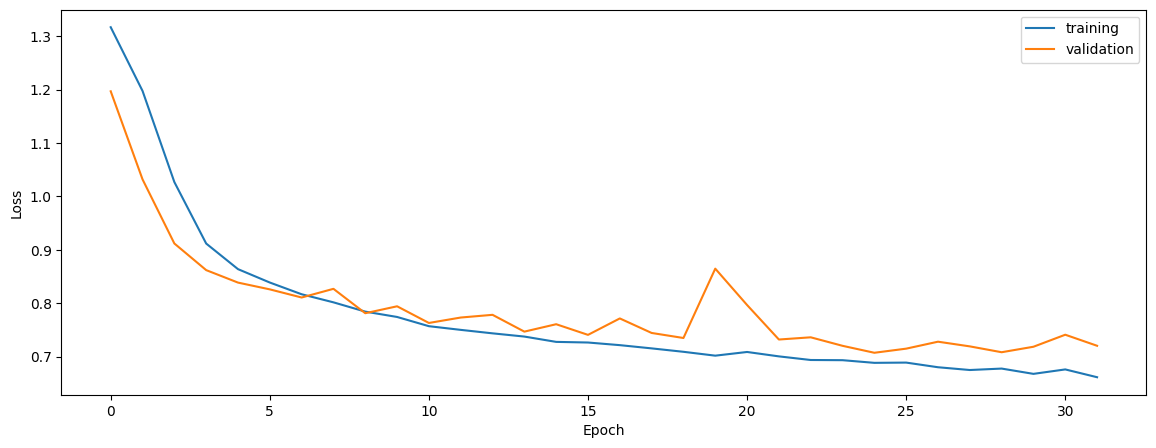

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7201003878621949
0.7217217082616179
0.7089023166528511


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7201003878621949
0.7217217082616179
0.7089023166528511


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.715304514095243
0.7128396963362306
0.709494030699261


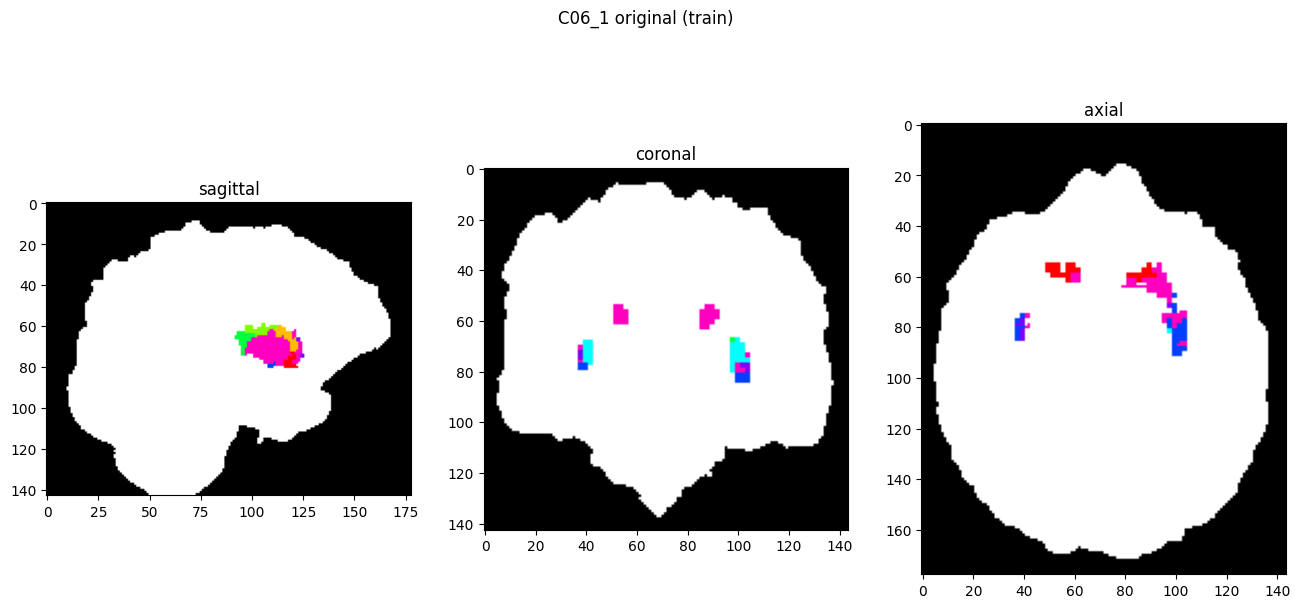

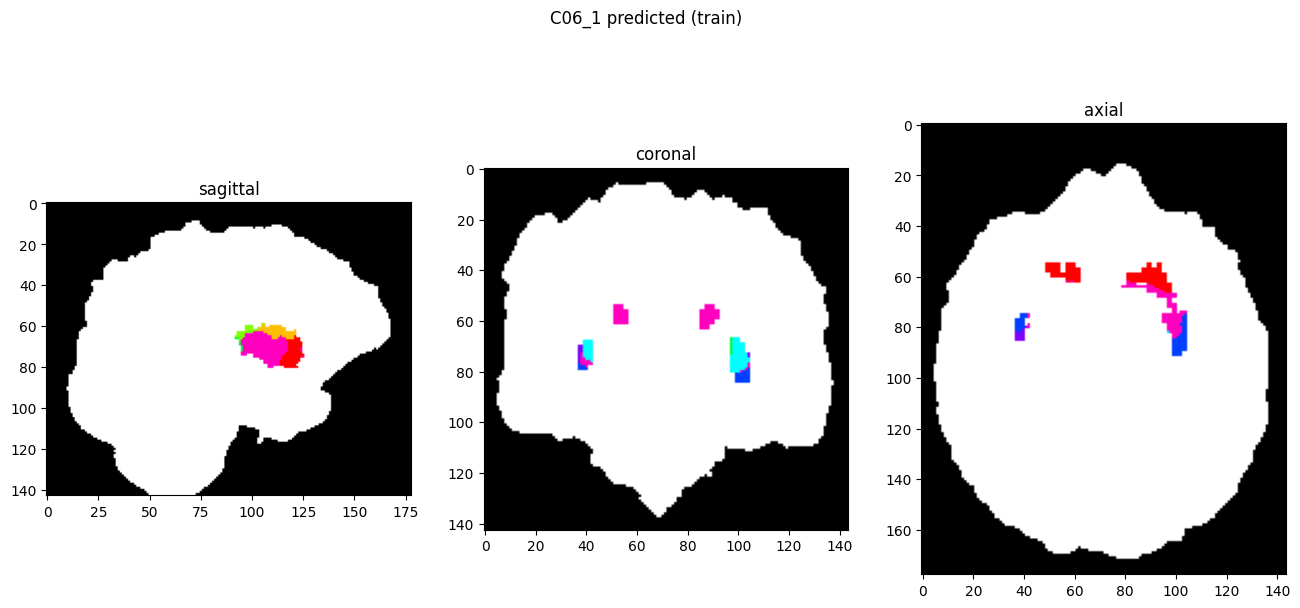

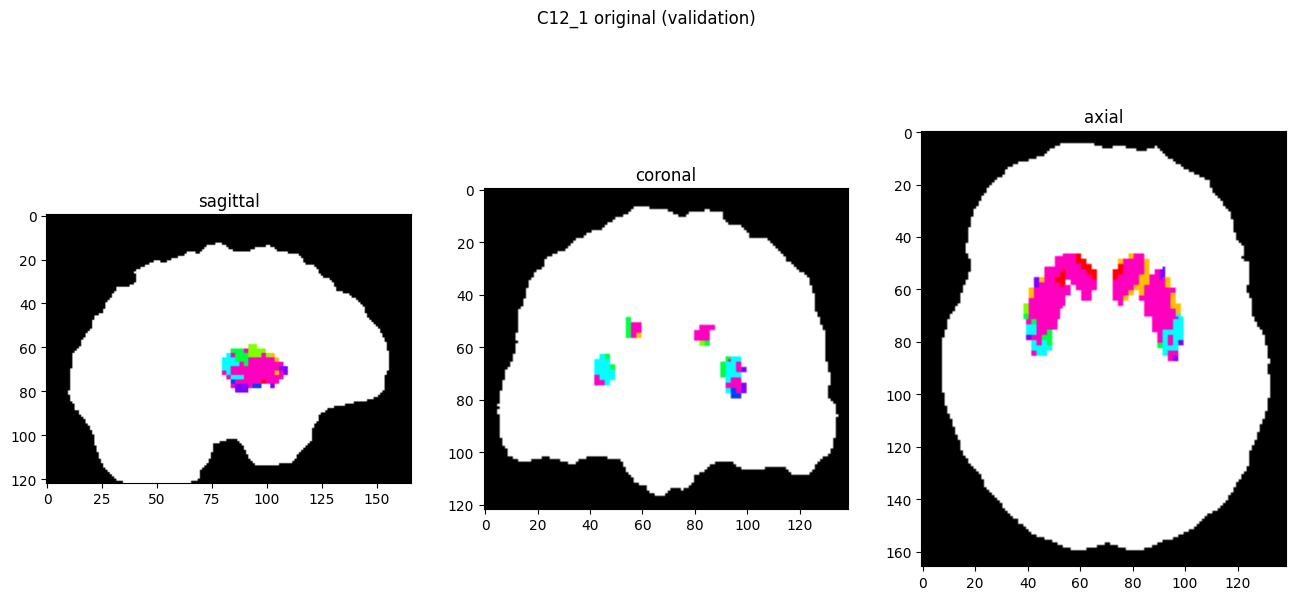

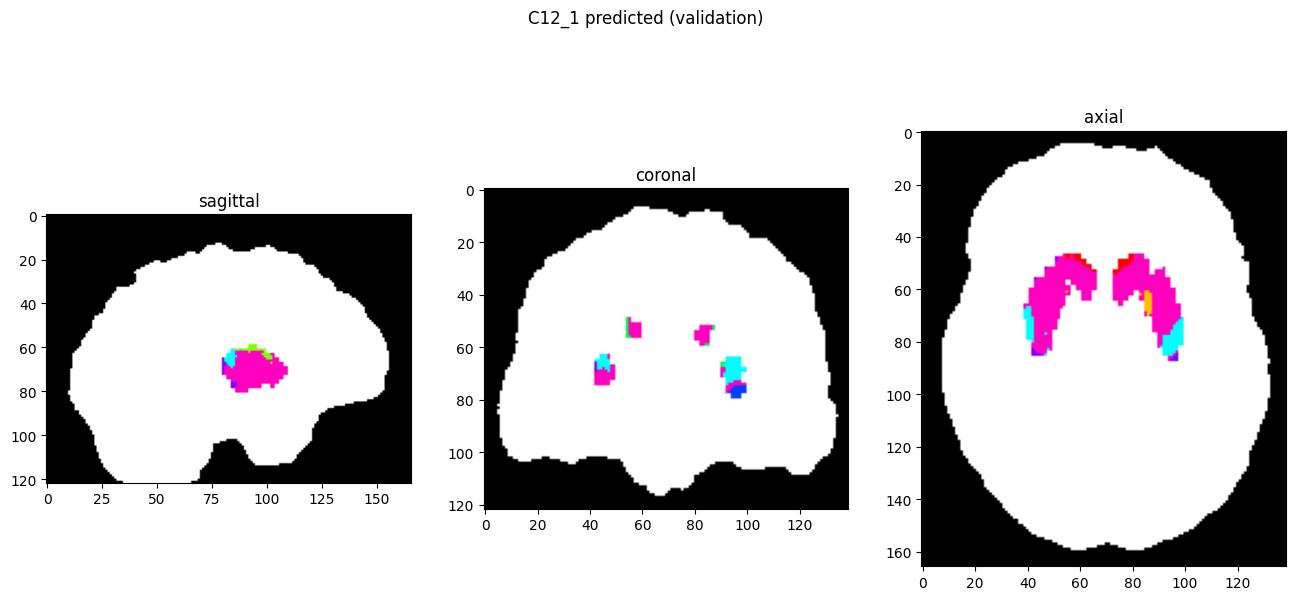

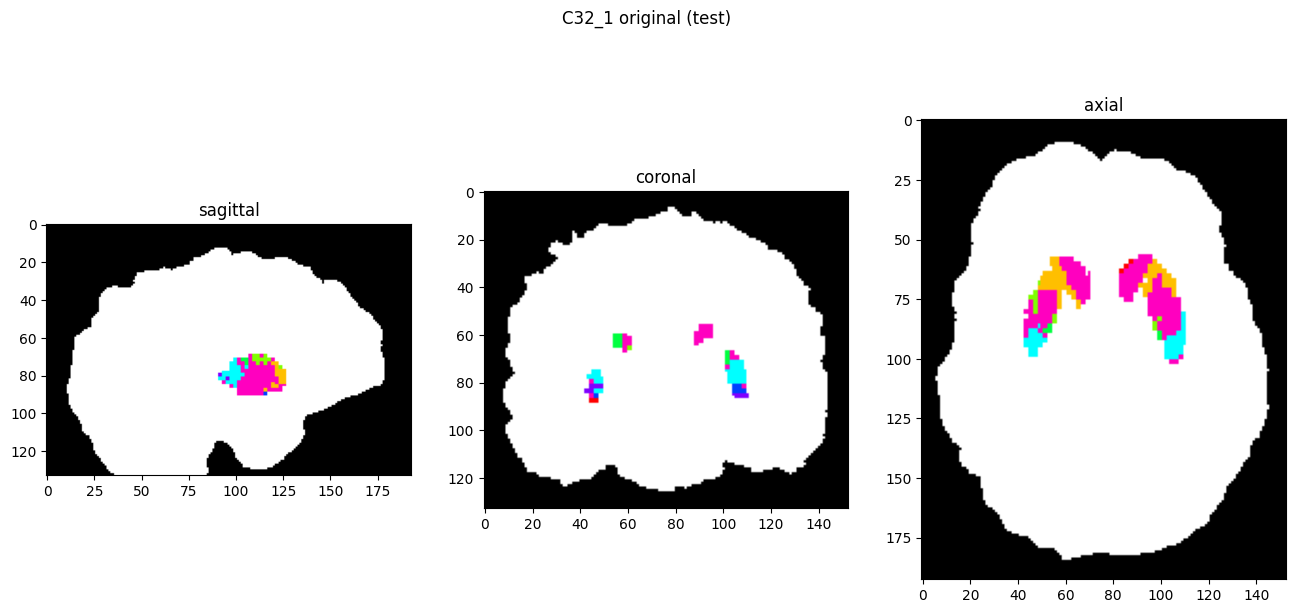

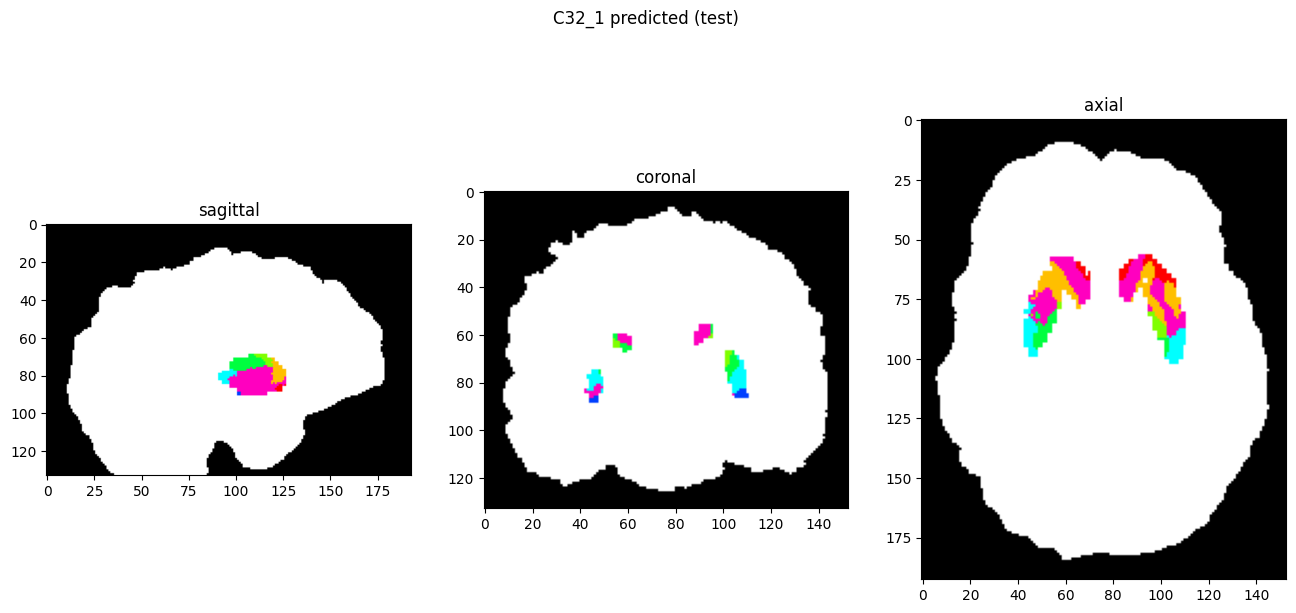

In [10]:
showResults(model, gen, threshold=0)